In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
logging.basicConfig(level=logging.INFO, format=' %(asctime)s - %(levelname)s - %(message)s')

import levy_stable_jax as lsj
import levy_stable_jax.estimation
import jax.numpy as jnp
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import numpy as np
from scipy.stats import levy_stable as sp_levy_stable
from scipy.stats import lognorm as sp_lognorm
import jax

sp_levy_stable.parameterization = "S0"


In [3]:
# (alpha, beta) = (1.5944529757446195, 0.9140602576756717)
# (alpha, beta) = (1.9999989999999999, 0.9999890000100001)
# (alpha, beta) = (1.2, -0.9999) #9999890000100001)
(alpha, beta) = (1.2, 0.9)
# alpha = 1.9193154521329552
# beta = 0.8991364476436018
loc, scale = 1.0, 2.0

 2024-05-23 14:26:39,353 - INFO - Unable to initialize backend 'cuda': 
 2024-05-23 14:26:39,354 - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
 2024-05-23 14:26:39,355 - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


<Axes: >

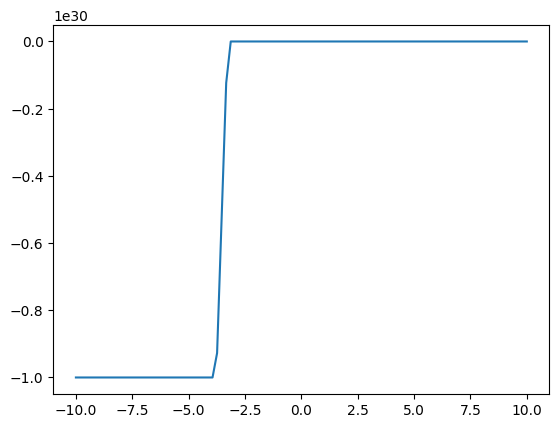

In [4]:
xs = jnp.linspace(-10, 10, 100)
sns.lineplot(x=xs,
             y=lsj.logpdf(xs, alpha,beta,loc, scale, "N0")-sp_levy_stable.logpdf(xs,alpha=alpha, beta=beta))
# sns.lineplot(x=xs,
#              y=sp_levy_stable.logpdf(xs,alpha=alpha, beta=beta))

<Axes: >

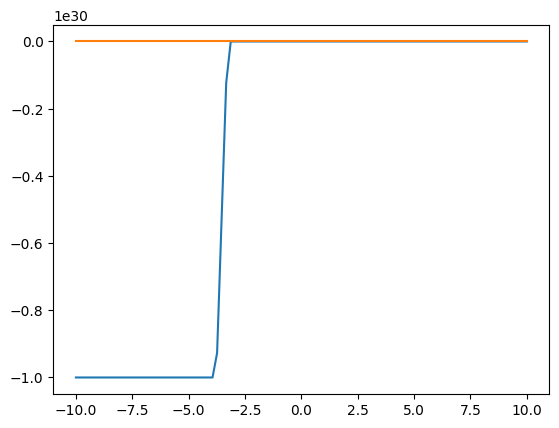

In [5]:
xs = jnp.linspace(-10, 10, 100)
sns.lineplot(x=xs,
             y=lsj.logpdf(xs, alpha,beta,loc=loc,scale=scale))
sns.lineplot(x=xs,
             y=sp_levy_stable.logpdf(xs,alpha=alpha, beta=beta,loc=loc,scale=scale))

# Check CDF

<Axes: >

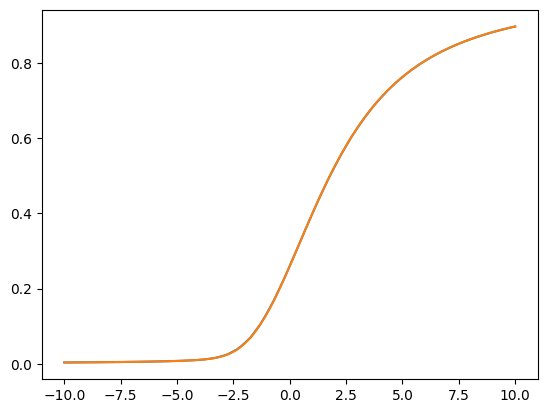

In [6]:
ys1 = lsj.cdf(xs, alpha, beta, loc, scale, "N0")
sns.lineplot(x=xs, y=ys1)
sns.lineplot(x=xs, y=sp_levy_stable.cdf(xs, alpha=alpha,beta=beta,loc=loc, scale=scale))

<Axes: >

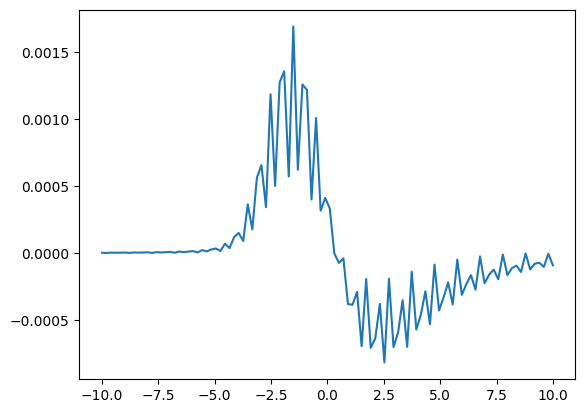

In [7]:
sns.lineplot(x=xs, y=ys1-sp_levy_stable.cdf(xs, alpha=alpha,beta=beta,loc=loc, scale=scale))

# Test fitting

In [8]:
from scipy.stats import lognorm as sp_lognorm

In [25]:

(s,scale_) = (0.2,jnp.exp(0))
ppf_thresh = 1e-3
ll = sp_lognorm.ppf([0.05,0.25,0.5,0.75,0.95], scale=scale_, s=s)
(x_low, x_high) = sp_lognorm.ppf([ppf_thresh, 1-ppf_thresh], scale=scale_, s=s)
xs = np.linspace(x_low, x_high,1000)
(q_alpha, q_beta, q_loc, q_scale) = levy_stable_jax.estimation.fit_quantiles(None,param="N1",percentiles=ll)
(ks_x_low, ks_x_high) = sp_lognorm.ppf([1e-2, 1-1e-2], scale=scale_, s=s)
ks_xs = np.linspace(ks_x_low, ks_x_high, 30)
ks_cdfs = sp_lognorm.cdf(ks_xs, scale=scale_, s=s)

(ks_alpha, ks_beta, ks_loc, ks_scale) = levy_stable_jax.estimation.fit_ks(ks_xs, ks_cdfs,param="N1",alpha=None)

start [1.924      1.         1.0203123  0.13872755]
res [1.924306   0.9        1.0166304  0.13785963]


quantiles (Array(1.9546816, dtype=float32), Array(1., dtype=float32), Array(1.0059813, dtype=float32), Array(0.14139512, dtype=float32))
KS (Array(1.924306, dtype=float32), Array(0.9, dtype=float32), Array(1.0166304, dtype=float32), Array(0.13785963, dtype=float32))


<Axes: >

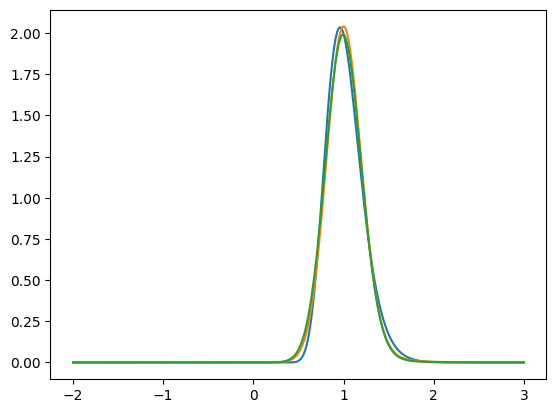

In [26]:
print("quantiles", (q_alpha, q_beta, q_loc, q_scale))
print("KS", (ks_alpha, ks_beta, ks_loc, ks_scale))
xs = np.linspace(-2, 3, 300)
sns.lineplot(
    x=xs,
    y=sp_lognorm.pdf(xs,scale=scale_,s=s))
sns.lineplot(
    x=xs,
    y=lsj.pdf(xs,ks_alpha,ks_beta,ks_loc,ks_scale,param="N1"))
sns.lineplot(
    x=xs,
    y=lsj.pdf(xs,q_alpha,q_beta,q_loc,q_scale,param="N1"))

In [22]:
def ks_score(ln_s, s_alpha, s_beta, s_loc, s_scale):
    ln_scale = 1.0 #np.exp(row["loc"])
    # ln_s = row["scale"]
    ppf_thresh = 1e-3
    (ln_x_low, ln_x_high) = sp_lognorm.ppf([ppf_thresh, 1-ppf_thresh], scale=ln_scale, s=ln_s)
    # Too slow
    # (sp_x_low, sp_x_high) = sp_levy_stable.ppf([ppf_thresh, 1-ppf_thresh], 
    #                                            alpha=row["s_alpha"], beta=row["s_beta"], loc=row["s_loc"], scale=row["s_scale"])
    dx = ln_x_high - ln_x_low
    x_low = ln_x_low - dx #min(ln_x_low, sp_x_low)
    x_high = ln_x_high + dx # max(ln_x_high, sp_x_high)
    xs = np.linspace(x_low, x_high, 100)
    ln_cdf = sp_lognorm.cdf(xs, scale=ln_scale, s=ln_s)
    # with lsj.set_stable(param):
    #     sp_cdf = sp_levy_stable.cdf(xs,alpha=row["s_alpha"], beta=row["s_beta"], loc=row["s_loc"], scale=row["s_scale"])
    sp_cdf = lsj.cdf(xs,alpha=s_alpha, beta=s_beta, loc=s_loc, scale=s_scale, param="N1")
    return np.max(np.abs(ln_cdf-sp_cdf))

ks_score(s, ks_alpha, ks_beta, ks_loc, ks_scale), ks_score(s, q_alpha, q_beta, q_loc, q_scale)

(0.030920088, 0.07786222)

In [12]:
s_s = np.linspace(0.01, 1.3, 200)
res = []
scores = []
for s in tqdm(s_s):
    (ks_x_low, ks_x_high) = sp_lognorm.ppf([1e-4, 1-1e-4], scale=1.0, s=s)
    ks_xs = np.linspace(ks_x_low, ks_x_high, 100)
    ks_cdfs = sp_lognorm.cdf(ks_xs, scale=1.0, s=s)
    
    p = levy_stable_jax.estimation.fit_ks(ks_xs, ks_cdfs,param="N1",alpha=None,beta=1.0)
    p = [x.item() for x in p]
    scores.append(ks_score(s, *p))
    res.append(p)

  0%|                                                                                       | 0/200 [00:00<?, ?it/s]

start [ 1.9925027  -0.          1.0003159   0.00708785]


  0%|▍                                                                              | 1/200 [00:09<32:47,  9.89s/it]

res [1.9925026  1.         1.0000602  0.00704547]
start [1.9928273  0.9587746  0.99996907 0.01168438]


  1%|▊                                                                              | 2/200 [00:14<21:42,  6.58s/it]

res [1.9928267 1.        1.0001614 0.0116843]
start [ 1.9925027  -0.          1.0010581   0.01629317]


  2%|█▏                                                                             | 3/200 [00:26<30:27,  9.28s/it]

res [1.992503   1.         1.00023    0.01617377]
start [1.9928273 0.9587746 1.0003684 0.0209038]


  2%|█▌                                                                             | 4/200 [00:34<28:46,  8.81s/it]

res [1.9928254 1.        1.0003549 0.0207661]
start [2.        1.        1.0021721 0.0255424]


  2%|█▉                                                                             | 5/200 [00:47<33:31, 10.31s/it]

res [1.9996741  1.         1.0003629  0.02532799]
start [1.9928273  0.9587746  1.0011332  0.03017183]


  3%|██▎                                                                            | 6/200 [00:54<29:19,  9.07s/it]

res [1.9928235  1.         1.0006467  0.02987953]
start [2.         1.         1.0036501  0.03484717]


  4%|██▊                                                                            | 7/200 [01:04<30:39,  9.53s/it]

res [1.9996253  1.         1.000694   0.03447518]
start [1.9928273  0.9587746  1.0022528  0.03951001]


  4%|███▏                                                                           | 8/200 [01:15<31:29,  9.84s/it]

res [1.9928215 1.        1.0010173 0.0389665]
start [1.889201   0.9397674  0.9980419  0.04145238]


  4%|███▌                                                                           | 9/200 [01:24<30:27,  9.57s/it]

res [1.8894471  1.         1.0040685  0.04196021]
start [1.9928273  0.9587746  1.0037124  0.04894007]


  5%|███▉                                                                          | 10/200 [01:32<28:36,  9.04s/it]

res [1.9928222  1.         1.0015101  0.04809481]
start [1.889201   0.9397674  0.9986141  0.05034456]


  6%|████▎                                                                         | 11/200 [01:38<26:04,  8.28s/it]

res [1.8894409  1.         1.0048732  0.05113819]
start [1.9928273  0.9587746  1.0054939  0.05848392]


  6%|████▋                                                                         | 12/200 [01:45<24:54,  7.95s/it]

res [1.9927816  1.         1.0022348  0.05693447]
start [2.         1.         1.003421   0.06333521]


  6%|█████                                                                         | 13/200 [01:53<24:24,  7.83s/it]

res [1.9989182  1.         1.0021931  0.06184829]
start [1.892119   1.         0.9962598  0.06390313]


  7%|█████▍                                                                        | 14/200 [01:59<23:01,  7.43s/it]

res [1.8921949  1.         1.0064974  0.06465321]
start [2.         1.         1.0051676  0.07309606]


  8%|█████▊                                                                        | 15/200 [02:05<21:21,  6.93s/it]

res [1.9994093 1.        1.0037462 0.0729395]
start [1.892119   1.         0.9969804  0.07312652]


  8%|██████▏                                                                       | 16/200 [02:15<23:58,  7.82s/it]

res [1.8922969  1.         1.0082337  0.07348799]
start [2.         1.         1.0071641  0.08302687]


  8%|██████▋                                                                       | 17/200 [02:20<20:44,  6.80s/it]

res [1.999232   1.         1.0049001  0.08289263]
start [1.892119   1.         0.9979134  0.08251996]


  9%|███████                                                                       | 18/200 [02:26<20:36,  6.79s/it]

res [1.8922029  1.         1.0095439  0.08273021]
start [2.         1.         1.0093768  0.09315075]


 10%|███████▍                                                                      | 19/200 [02:33<20:11,  6.69s/it]

res [1.9981726 1.        1.0046116 0.0892287]
start [1.9604468  1.         1.0029993  0.09258223]


 10%|███████▊                                                                      | 20/200 [02:41<21:09,  7.05s/it]

res [1.9604552  1.         1.0070302  0.09281155]
start [1.9606441  1.         0.998342   0.09748032]


 10%|████████▏                                                                     | 21/200 [02:48<21:05,  7.07s/it]

res [1.9602876  1.         1.0076869  0.09732094]
start [1.9604468  1.         1.0046593  0.10243246]


 11%|████████▌                                                                     | 22/200 [02:56<22:06,  7.45s/it]

res [1.9604682  1.         1.008218   0.10176732]
start [1.9606441  1.         0.9994948  0.10744688]


 12%|████████▉                                                                     | 23/200 [03:04<22:45,  7.71s/it]

res [1.9602807  1.         1.0088762  0.10630196]
start [2.        1.        1.0092599 0.1128241]


 12%|█████████▎                                                                    | 24/200 [03:08<18:53,  6.44s/it]

res [1.9991362  1.         1.0074753  0.11259907]
start [1.9606441  1.         1.0007004  0.11766328]


 12%|█████████▊                                                                    | 25/200 [03:14<18:14,  6.25s/it]

res [1.9602671  1.         1.0101593  0.11524467]
start [2.         1.         1.0113144  0.12320205]


 13%|██████████▏                                                                   | 26/200 [03:22<20:00,  6.90s/it]

res [1.997717   1.         1.0083717  0.12095856]
start [1.9606441  1.         1.0019027  0.12815328]


 14%|██████████▌                                                                   | 27/200 [03:31<21:51,  7.58s/it]

res [1.9602308 1.        1.0115721 0.1242415]
start [1.8568201  1.         1.0022267  0.12441225]


 14%|██████████▉                                                                   | 28/200 [03:41<23:56,  8.35s/it]

res [1.8574473  1.         1.0207237  0.12577528]
start [2.         1.         1.0065398  0.13931383]


 14%|███████████▎                                                                  | 29/200 [03:49<22:40,  7.95s/it]

res [1.9955198  1.         1.0105354  0.13451578]
start [1.8568201 1.        1.0032859 0.1346128]


 15%|███████████▋                                                                  | 30/200 [03:56<22:17,  7.87s/it]

res [1.857534   1.         1.0228494  0.13443781]
start [2.        1.        1.007825  0.1504547]


 16%|████████████                                                                  | 31/200 [04:03<21:05,  7.49s/it]

res [1.9951172 1.        1.0119032 0.143516 ]
start [1.924      1.         1.0100499  0.14621198]


 16%|████████████▍                                                                 | 32/200 [04:08<19:14,  6.87s/it]

res [1.9240146  1.         1.0189879  0.14408833]
start [1.8616982  1.         0.99587137 0.15060699]


 16%|████████████▊                                                                 | 33/200 [04:15<19:02,  6.84s/it]

res [1.8617872  1.         1.0255396  0.14741828]
start [1.924      1.         1.0111345  0.15714417]


 17%|█████████████▎                                                                | 34/200 [04:30<25:39,  9.27s/it]

res [1.7837329  1.         1.0360402  0.14983998]
start [1.924      1.         1.0018107  0.16274567]


 18%|█████████████▋                                                                | 35/200 [04:36<22:33,  8.20s/it]

res [1.9234632 1.        1.0241178 0.1620655]
start [2.        1.        1.0200987 0.169314 ]


 18%|██████████████                                                                | 36/200 [04:48<25:44,  9.42s/it]

res [2.         1.         1.0154586  0.16641086]
start [1.924      1.         1.0017035  0.17423576]


 18%|██████████████▍                                                               | 37/200 [04:52<21:26,  7.89s/it]

res [1.9229369 1.        1.0275831 0.1728495]
start [2.         1.         1.0210359  0.18106379]


 19%|██████████████▊                                                               | 38/200 [05:00<20:52,  7.73s/it]

res [2.         1.         1.0204626  0.18098909]
start [2.         1.         1.0101758  0.18709482]


 20%|███████████████▏                                                              | 39/200 [05:06<19:48,  7.38s/it]

res [2.         1.         1.020825   0.18458577]
start [1.8257179 1.        1.0022866 0.1781405]


 20%|███████████████▌                                                              | 40/200 [05:12<18:05,  6.78s/it]

res [1.827015   1.         1.0374002  0.17651118]
start [1.829      1.         0.9901365  0.18398514]


 20%|███████████████▉                                                              | 41/200 [05:18<17:59,  6.79s/it]

res [1.829739   1.         1.0391619  0.18060657]
start [1.8923334  1.         1.0082515  0.19148411]


 21%|████████████████▍                                                             | 42/200 [05:25<17:40,  6.71s/it]

res [1.8924946  1.         1.0325601  0.18772833]
start [1.8923334  1.         0.99486375 0.1975189 ]


 22%|████████████████▊                                                             | 43/200 [05:29<15:31,  5.93s/it]

res [1.890464   1.         1.036345   0.19476756]
start [1.8923334  1.         1.0066024  0.20366849]


 22%|█████████████████▏                                                            | 44/200 [05:38<17:35,  6.77s/it]

res [1.8923061  1.         1.0351129  0.19633855]
start [1.791054   1.         0.9816703  0.19316971]


 22%|█████████████████▌                                                            | 45/200 [05:47<19:28,  7.54s/it]

res [1.790284  1.        1.0508766 0.1959402]
start [1.96553    1.         1.014134   0.21751554]


 23%|█████████████████▉                                                            | 46/200 [05:53<17:54,  6.98s/it]

res [1.9637686  1.         1.0292126  0.20917282]
start [1.791054   1.         0.9772435  0.20504472]


 24%|██████████████████▎                                                           | 47/200 [06:00<18:19,  7.19s/it]

res [1.7893174  1.         1.0539689  0.20259045]
start [1.96553    1.         1.0112755  0.23074886]


 24%|██████████████████▋                                                           | 48/200 [06:08<18:21,  7.24s/it]

res [1.9600915  1.         1.031859   0.21770659]
start [2.        1.        1.0298315 0.2381227]


 24%|███████████████████                                                           | 49/200 [06:15<17:57,  7.13s/it]

res [2.         1.         1.0277148  0.22485638]
start [1.8561429  1.         0.99242014 0.22586472]


 25%|███████████████████▌                                                          | 50/200 [06:22<18:22,  7.35s/it]

res [1.8546945 1.        1.0484066 0.2197873]
start [1.96553    1.         1.0209352  0.25161484]


 26%|███████████████████▉                                                          | 51/200 [06:29<17:35,  7.09s/it]

res [1.962254   1.         1.0353988  0.23123662]
start [1.8561429  1.         0.9863547  0.23910932]


 26%|████████████████████▎                                                         | 52/200 [06:37<17:51,  7.24s/it]

res [1.85203    1.         1.051771   0.22838978]
start [1.8561429  1.         0.9997662  0.24593814]


 26%|████████████████████▋                                                         | 53/200 [06:45<18:26,  7.53s/it]

res [1.8528966  1.         1.053327   0.23283257]
start [1.924      1.         0.98918563 0.25482503]


 27%|█████████████████████                                                         | 54/200 [06:54<19:42,  8.10s/it]

res [1.687605   1.         1.0778364  0.22889368]
start [1.924     1.        1.0030757 0.2619977]


 28%|█████████████████████▍                                                        | 55/200 [07:00<18:10,  7.52s/it]

res [1.9166236  1.         1.0466791  0.24537875]
start [1.7482967  1.         0.9936091  0.24375576]


 28%|█████████████████████▊                                                        | 56/200 [07:12<21:16,  8.87s/it]

res [1.6110002  1.         1.11352    0.23075366]
start [1.924      1.         0.9946936  0.27680415]


 28%|██████████████████████▏                                                       | 57/200 [07:19<19:51,  8.33s/it]

res [1.9143538 1.        1.0499344 0.2541624]
start [1.8160045  1.         0.9935384  0.26073578]


 29%|██████████████████████▌                                                       | 58/200 [07:31<22:01,  9.30s/it]

res [1.6047776  1.         1.1206086  0.23876569]
start [1.8160045  1.         1.0083098  0.26789266]


 30%|███████████████████████                                                       | 59/200 [07:37<19:12,  8.18s/it]

res [1.8166844  1.         1.0704063  0.25651023]
start [1.8874615  1.         0.9939511  0.27786237]


 30%|███████████████████████▍                                                      | 60/200 [07:46<19:48,  8.49s/it]

res [1.8808085  1.         1.0598133  0.26418197]
start [1.8160045 1.        0.997374  0.2826778]


 30%|███████████████████████▊                                                      | 61/200 [08:03<25:28, 10.99s/it]

res [1.5856477  1.         1.1347426  0.24911726]
start [1.8874615  1.         0.9814417  0.29311764]


 31%|████████████████████████▏                                                     | 62/200 [08:13<24:35, 10.69s/it]

res [1.8772625  1.         1.063577   0.27285007]
start [1.7071667 1.        0.9709416 0.2694606]


 32%|████████████████████████▌                                                     | 63/200 [08:17<20:02,  8.78s/it]

res [1.7066162  1.         1.1058596  0.26819992]
start [1.9719193  1.         1.0288185  0.31109306]


 32%|████████████████████████▉                                                     | 64/200 [08:32<24:14, 10.69s/it]

res [1.5843868  1.         1.1429105  0.26083413]
start [1.773      1.         0.96460104 0.28786558]


 32%|█████████████████████████▎                                                    | 65/200 [08:42<23:27, 10.43s/it]

res [1.553503  1.        1.1569064 0.2636159]
start [1.8448334  1.         0.99178123 0.29893357]


 33%|█████████████████████████▋                                                    | 66/200 [08:58<27:14, 12.20s/it]

res [1.6056755 1.        1.1408322 0.2700586]
start [1.773      1.         0.99562377 0.30331558]


 34%|██████████████████████████▏                                                   | 67/200 [09:05<23:45, 10.72s/it]

res [1.7709858  1.         1.0932049  0.28163165]
start [1.773      1.         0.96120954 0.31130275]


 34%|██████████████████████████▌                                                   | 68/200 [09:11<20:02,  9.11s/it]

res [1.7637864  1.         1.097161   0.28828558]
start [1.8448334  1.         0.98976296 0.3231778 ]


 34%|██████████████████████████▉                                                   | 69/200 [09:23<21:39,  9.92s/it]

res [1.5322107 1.        1.1812077 0.2764845]
start [1.8448334  1.         1.006299   0.33162853]


 35%|███████████████████████████▎                                                  | 70/200 [09:34<22:32, 10.40s/it]

res [1.5201598  1.         1.185916   0.27750778]
start [1.7250909  1.         0.95102704 0.30534938]


 36%|███████████████████████████▋                                                  | 71/200 [09:42<20:57,  9.75s/it]

res [1.7165866  1.         1.1158555  0.29659212]
start [1.924      1.         1.0014021  0.35229215]


 36%|████████████████████████████                                                  | 72/200 [09:50<19:21,  9.07s/it]

res [1.5094873  1.         1.2018149  0.28504738]
start [1.7243637  1.         0.9831356  0.32135192]


 36%|████████████████████████████▍                                                 | 73/200 [09:55<16:55,  8.00s/it]

res [1.7234259 1.        1.1178962 0.3039551]
start [1.7243637  1.         1.0001007  0.32965344]


 37%|████████████████████████████▊                                                 | 74/200 [10:01<15:14,  7.26s/it]

res [1.4901742  1.         1.2113752  0.28591472]
start [1.7250909  1.         0.95699465 0.33819637]


 38%|█████████████████████████████▎                                                | 75/200 [10:04<12:22,  5.94s/it]

res [1.6427346  1.         1.1478175  0.30596802]
start [1.7984545  1.         0.9871779  0.35211402]


 38%|█████████████████████████████▋                                                | 76/200 [10:10<12:20,  5.97s/it]

res [1.7887053  1.         1.1078571  0.32225004]
start [1.7984545  1.         1.0046718  0.36114058]


 38%|██████████████████████████████                                                | 77/200 [10:14<11:26,  5.58s/it]

res [1.7912601 1.        1.1091317 0.3266253]
start [1.8808181 1.        0.9748399 0.3745368]


 39%|██████████████████████████████▍                                               | 78/200 [10:20<11:13,  5.52s/it]

res [1.8459301  1.         1.0986612  0.33597085]
start [1.6731429  1.         0.9563087  0.33591262]


 40%|██████████████████████████████▊                                               | 79/200 [10:27<12:13,  6.06s/it]

res [1.6691025  1.         1.1490073  0.32321146]
start [1.6731429 1.        0.9734189 0.3444668]


 40%|███████████████████████████████▏                                              | 80/200 [10:40<16:04,  8.04s/it]

res [1.4547498 1.        1.2655666 0.3089325]
start [1.8808181 1.        1.0289297 0.403886 ]


 40%|███████████████████████████████▌                                              | 81/200 [10:41<12:01,  6.06s/it]

res [1.8657767 1.        1.1008554 0.3463203]
start [1.6731429  1.         0.9368367  0.36218092]


 41%|███████████████████████████████▉                                              | 82/200 [10:47<11:36,  5.90s/it]

res [1.4807866  1.         1.2483755  0.31633726]
start [1.745      1.         0.96752506 0.37758243]


 42%|████████████████████████████████▎                                             | 83/200 [10:59<15:01,  7.71s/it]

res [1.4363337  1.         1.292474   0.31791317]
start [1.745     1.        0.9854281 0.387126 ]


 42%|████████████████████████████████▊                                             | 84/200 [11:07<15:22,  7.96s/it]

res [1.7377925  1.         1.1393603  0.34957084]
start [1.5474629  1.         0.9774939  0.33792305]


 42%|█████████████████████████████████▏                                            | 85/200 [11:17<16:02,  8.37s/it]

res [1.4032581  1.         1.3287922  0.31843433]
start [1.6178974  1.         0.92650473 0.35468003]


 43%|█████████████████████████████████▌                                            | 86/200 [11:25<16:00,  8.43s/it]

res [1.6099325  1.         1.1893523  0.34019554]
start [1.829     1.        0.9797963 0.4234829]


 44%|█████████████████████████████████▉                                            | 87/200 [11:35<16:55,  8.99s/it]

res [1.4044402 1.        1.3441604 0.3306447]
start [1.829      1.         0.9984781  0.43412068]


 44%|██████████████████████████████████▎                                           | 88/200 [11:42<15:32,  8.32s/it]

res [1.8054746 1.        1.1301973 0.3716627]
start [1.6894667  1.         0.9929177  0.38977024]


 44%|██████████████████████████████████▋                                           | 89/200 [11:48<13:49,  7.47s/it]

res [1.6867156  1.         1.1707536  0.36527848]
start [1.6894667 1.        1.0121496 0.3995351]


 45%|███████████████████████████████████                                           | 90/200 [11:53<12:37,  6.88s/it]

res [1.6828935  1.         1.1886948  0.37981126]
start [1.6178974 1.        0.927548  0.4014585]


 46%|███████████████████████████████████▍                                          | 91/200 [12:07<16:27,  9.06s/it]

res [1.5771968  1.         1.2207414  0.35760462]
start [1.4874876  1.         0.93575126 0.3494562 ]


 46%|███████████████████████████████████▉                                          | 92/200 [12:14<14:49,  8.23s/it]

res [1.4902096 1.        1.2783743 0.3513347]
start [1.6894667  1.         0.9781506  0.43024635]


 46%|████████████████████████████████████▎                                         | 93/200 [12:27<17:10,  9.63s/it]

res [1.3500782  1.         1.4303038  0.33894163]
start [1.6894667  1.         0.9974304  0.44097552]


 47%|████████████████████████████████████▋                                         | 94/200 [12:33<15:18,  8.67s/it]

res [1.6786935  1.         1.1837837  0.37826115]
start [1.773      1.         0.93709093 0.46006355]


 48%|█████████████████████████████████████                                         | 95/200 [12:45<16:48,  9.60s/it]

res [1.3532387 1.        1.4389082 0.3485564]
start [1.547      1.         0.91856694 0.39417925]


 48%|█████████████████████████████████████▍                                        | 96/200 [12:52<15:21,  8.86s/it]

res [1.5403162  1.         1.2579149  0.37193266]
start [1.547      1.         0.9366577  0.40398026]


 48%|█████████████████████████████████████▊                                        | 97/200 [13:01<15:25,  8.98s/it]

res [1.5429093  1.         1.2599025  0.37648794]
start [1.6271223 1.        0.9700413 0.4250164]


 49%|██████████████████████████████████████▏                                       | 98/200 [13:08<14:18,  8.42s/it]

res [1.6206344  1.         1.2204428  0.38930708]
start [1.6271223 1.        0.9895978 0.4355659]


 50%|██████████████████████████████████████▌                                       | 99/200 [13:16<13:57,  8.29s/it]

res [1.6113844 1.        1.241024  0.4023295]
start [1.6271223  1.         1.0097295  0.44636858]


 50%|██████████████████████████████████████▌                                      | 100/200 [13:39<21:12, 12.73s/it]

res [1.2834688  1.         1.588336   0.34940252]
start [1.7105    1.        0.9330606 0.4678148]


 50%|██████████████████████████████████████▉                                      | 101/200 [13:45<17:22, 10.53s/it]

res [1.6811023 1.        1.2000434 0.3937179]
start [1.7105     1.         0.9519664  0.47939995]


 51%|███████████████████████████████████████▎                                     | 102/200 [13:48<13:41,  8.38s/it]

res [1.1659479  1.         2.1170123  0.34423026]
start [1.7105     1.         0.97142553 0.49126375]


 52%|███████████████████████████████████████▋                                     | 103/200 [13:54<12:18,  7.61s/it]

res [1.6850158  1.         1.2064986  0.41150218]
start [1.7095909  1.         0.991209   0.50332075]


 52%|████████████████████████████████████████                                     | 104/200 [14:05<13:39,  8.53s/it]

res [1.686881   1.         1.209274   0.41967857]
start [1.4782987  1.         0.97808456 0.4188785 ]


 52%|████████████████████████████████████████▍                                    | 105/200 [14:12<13:12,  8.34s/it]

res [1.2644072 1.        1.672009  0.3635821]
start [1.4782987 1.        0.9984338 0.4292249]


 53%|████████████████████████████████████████▊                                    | 106/200 [14:15<10:19,  6.59s/it]

res [1.2154223 1.        1.8216467 0.3532091]
start [1.547      1.         0.8976163  0.45142567]


 54%|█████████████████████████████████████████▏                                   | 107/200 [14:26<12:17,  7.93s/it]

res [1.2915374  1.         1.6394932  0.38487214]
start [1.808      1.         0.96902734 0.56581914]


 54%|█████████████████████████████████████████▌                                   | 108/200 [14:29<09:49,  6.41s/it]

res [1.2312305  1.         1.760634   0.36580962]
start [1.547      1.         0.9351854  0.47397023]


 55%|█████████████████████████████████████████▉                                   | 109/200 [14:38<10:58,  7.24s/it]

res [1.5281197  1.         1.3013692  0.40260518]
start [1.547      1.         0.95477974 0.48565242]


 55%|██████████████████████████████████████████▎                                  | 110/200 [14:42<09:24,  6.27s/it]

res [1.1874359  1.         2.0101576  0.36182535]
start [1.6391429  1.         0.99555045 0.51253986]


 56%|██████████████████████████████████████████▋                                  | 111/200 [14:45<07:39,  5.17s/it]

res [1.217113   1.         1.884786   0.38444647]
start [1.6391429 1.        1.0167742 0.5251611]


 56%|███████████████████████████████████████████                                  | 112/200 [14:58<11:12,  7.64s/it]

res [1.1        1.         2.9357586  0.33909258]
start [1.6391429 1.        1.038589  0.5380875]


 56%|███████████████████████████████████████████▌                                 | 113/200 [15:01<08:48,  6.07s/it]

res [1.1896354  1.         2.0476677  0.38305044]
start [1.4612105  1.         0.88379633 0.44364128]


 57%|███████████████████████████████████████████▉                                 | 114/200 [15:12<11:02,  7.71s/it]

res [1.4437239 1.        1.4039998 0.4196412]
start [1.4612105  1.         0.90247303 0.45455244]


 57%|████████████████████████████████████████████▎                                | 115/200 [15:18<09:59,  7.05s/it]

res [1.1831042 1.        2.0977647 0.3823144]
start [1.4612105  1.         0.92167425 0.46572778]


 58%|████████████████████████████████████████████▋                                | 116/200 [15:26<10:25,  7.44s/it]

res [1.4560981  1.         1.3973985  0.42775017]
start [1.4612105  1.         0.94141114 0.47717384]


 58%|█████████████████████████████████████████████                                | 117/200 [15:32<09:54,  7.17s/it]

res [1.1       1.        3.015368  0.3521417]
start [1.547      1.         0.97894645 0.5056096 ]


 59%|█████████████████████████████████████████████▍                               | 118/200 [15:39<09:25,  6.90s/it]

res [1.5448844  1.         1.3358996  0.45290458]
start [1.8561429  1.         1.0758837  0.65105563]


 60%|█████████████████████████████████████████████▊                               | 119/200 [15:41<07:32,  5.58s/it]

res [1.1896821  1.         2.1073115  0.39846444]
start [1.547      1.         1.0220613  0.53074676]


 60%|██████████████████████████████████████████████▏                              | 120/200 [15:50<08:35,  6.44s/it]

res [1.159359   1.         2.3233833  0.38747007]
start [1.547      1.         1.0445035  0.54377437]


 60%|██████████████████████████████████████████████▌                              | 121/200 [15:58<09:05,  6.91s/it]

res [1.1295099  1.         2.6443727  0.38255718]
start [1.6545     1.         0.90152127 0.57627755]


 61%|██████████████████████████████████████████████▉                              | 122/200 [16:02<07:52,  6.06s/it]

res [1.1569641  1.         2.3899808  0.40471113]
start [1.6545     1.         0.9211179  0.59041506]


 62%|███████████████████████████████████████████████▎                             | 123/200 [16:05<06:45,  5.27s/it]

res [1.3382059  1.         1.561983   0.41640908]
start [1.6545    1.        0.9412499 0.6048957]


 62%|███████████████████████████████████████████████▋                             | 124/200 [16:07<05:21,  4.23s/it]

res [1.1        1.         3.2766714  0.39736027]
start [1.6545     1.         0.96192896 0.619728  ]


 62%|████████████████████████████████████████████████▏                            | 125/200 [16:22<09:20,  7.47s/it]

res [1.1432828 1.        2.538144  0.3979104]
start [1.371647   1.         0.9458859  0.47417548]


 63%|████████████████████████████████████████████████▌                            | 126/200 [16:29<09:12,  7.47s/it]

res [1.1677296 1.        2.362887  0.419264 ]
start [1.371647   1.         0.9667818  0.48579723]


 64%|████████████████████████████████████████████████▉                            | 127/200 [16:38<09:24,  7.73s/it]

res [1.1758997 1.        2.305571  0.4245481]
start [1.371647   1.         0.98823965 0.49770135]


 64%|█████████████████████████████████████████████████▎                           | 128/200 [16:49<10:36,  8.84s/it]

res [1.154266   1.         2.474557   0.41332534]
start [1.371647  1.        1.0102719 0.5098947]


 64%|█████████████████████████████████████████████████▋                           | 129/200 [16:57<10:07,  8.55s/it]

res [1.1000073  1.         3.2846594  0.39648303]
start [1.448     1.        1.0480783 0.5417298]


 65%|██████████████████████████████████████████████████                           | 130/200 [16:59<07:44,  6.64s/it]

res [1.1        1.         3.4771833  0.42948943]
start [1.44175    1.         0.82998365 0.5534793 ]


 66%|██████████████████████████████████████████████████▍                          | 131/200 [17:07<07:57,  6.92s/it]

res [1.1        1.         3.3268342  0.40354013]
start [1.44175   1.        0.8482803 0.5670319]


 66%|██████████████████████████████████████████████████▊                          | 132/200 [17:14<07:53,  6.97s/it]

res [1.1114826 1.        3.147162  0.4177271]
start [1.19375    1.         0.86737776 0.40302074]


 66%|███████████████████████████████████████████████████▏                         | 133/200 [17:14<05:31,  4.94s/it]

res [1.19375    1.         2.1504748  0.40302074]
start [1.44175   1.        0.8863636 0.5951339]


 67%|███████████████████████████████████████████████████▌                         | 134/200 [17:16<04:26,  4.04s/it]

res [1.2898794  1.         1.7235128  0.42361555]
start [1.547      1.         0.9324535  0.63595617]


 68%|███████████████████████████████████████████████████▉                         | 135/200 [17:19<04:01,  3.71s/it]

res [1.2147331  1.         2.1104374  0.45350844]
start [1.547     1.        0.9534322 0.6515188]


 68%|████████████████████████████████████████████████████▎                        | 136/200 [17:21<03:17,  3.08s/it]

res [1.3303567  1.         1.7265954  0.48754737]
start [1.547      1.         0.97496504 0.6674601 ]


 68%|████████████████████████████████████████████████████▋                        | 137/200 [17:22<02:35,  2.46s/it]

res [1.4932537 1.        1.423842  0.4789073]
start [1.547      1.         0.99706453 0.6837894 ]


 69%|█████████████████████████████████████████████████████▏                       | 138/200 [17:32<04:49,  4.68s/it]

res [1.1        1.         3.5489368  0.43869734]
start [1.547     1.        1.0197436 0.7005161]


 70%|█████████████████████████████████████████████████████▌                       | 139/200 [17:44<07:04,  6.96s/it]

res [1.1        1.         3.5103467  0.43354943]
start [1.676      1.         1.0857321  0.74679804]


 70%|█████████████████████████████████████████████████████▉                       | 140/200 [17:54<07:54,  7.91s/it]

res [1.1128793  1.         3.252439   0.44385326]
start [1.3302143 1.        1.0582341 0.5332293]


 70%|██████████████████████████████████████████████████████▎                      | 141/200 [18:10<10:06, 10.29s/it]

res [1.1        1.         3.5566444  0.44106928]
start [1.3302143 1.        1.0825205 0.5462687]


 71%|██████████████████████████████████████████████████████▋                      | 142/200 [18:22<10:35, 10.96s/it]

res [1.1003183 1.        3.6203465 0.4522314]
start [1.3302143  1.         1.107436   0.55962557]


 72%|███████████████████████████████████████████████████████                      | 143/200 [18:31<09:45, 10.28s/it]

res [1.1        1.         3.607432   0.44925976]
start [1.318      1.         0.80145043 0.5696111 ]


 72%|███████████████████████████████████████████████████████▍                     | 144/200 [18:39<08:58,  9.61s/it]

res [1.1        1.         3.62976    0.45287862]
start [1.4184422  1.         0.84129953 0.6148109 ]


 72%|███████████████████████████████████████████████████████▊                     | 145/200 [18:53<09:54, 10.80s/it]

res [1.1        1.         3.6441238  0.45507073]
start [1.4184422  1.         0.86041987 0.62983954]


 73%|████████████████████████████████████████████████████████▏                    | 146/200 [19:01<08:57,  9.96s/it]

res [1.1        1.         3.6583066  0.45721278]
start [1.4184422  1.         0.8800403  0.64523435]


 74%|████████████████████████████████████████████████████████▌                    | 147/200 [19:08<08:08,  9.21s/it]

res [1.1        1.         3.6293967  0.45207846]
start [1.4184422  1.         0.90017223 0.6610041 ]


 74%|████████████████████████████████████████████████████████▉                    | 148/200 [19:17<07:55,  9.14s/it]

res [1.1       1.        3.6478872 0.4549241]
start [1.4184422 1.        0.9208274 0.6771581]


 74%|█████████████████████████████████████████████████████████▎                   | 149/200 [19:24<07:11,  8.46s/it]

res [1.1        1.         3.6704192  0.45844725]
start [1.4184422  1.         0.94201773 0.6937057 ]


 75%|█████████████████████████████████████████████████████████▊                   | 150/200 [19:31<06:37,  7.95s/it]

res [1.1       1.        3.678192  0.4594255]
start [1.1883334  1.         0.9839054  0.46486947]


 76%|██████████████████████████████████████████████████████████▏                  | 151/200 [19:37<06:04,  7.45s/it]

res [1.1        1.         3.6803958  0.45990276]
start [1.1883334  1.         1.0066957  0.47622788]


 76%|██████████████████████████████████████████████████████████▌                  | 152/200 [19:40<04:48,  6.01s/it]

res [1.209545   1.         2.2359889  0.48253483]
start [1.1883334  1.         1.0300713  0.48786306]


 76%|██████████████████████████████████████████████████████████▉                  | 153/200 [19:40<03:23,  4.32s/it]

res [1.1883334  1.         2.6307938  0.48786306]
start [1.1883334  1.         1.0540456  0.49978182]


 77%|███████████████████████████████████████████████████████████▎                 | 154/200 [19:40<02:23,  3.13s/it]

res [1.1883334  1.         2.6938746  0.49978182]
start [1.1883334 1.        1.0786325 0.5119911]


 78%|███████████████████████████████████████████████████████████▋                 | 155/200 [19:41<01:43,  2.29s/it]

res [1.1883334 1.        2.758521  0.5119911]
start [1.1883334 1.        1.1038462 0.5244979]


 78%|████████████████████████████████████████████████████████████                 | 156/200 [19:43<01:37,  2.22s/it]

res [1.2177016  1.         2.2357426  0.49923474]
start [1.2801212  1.         1.1443373  0.57151246]


 78%|████████████████████████████████████████████████████████████▍                | 157/200 [19:49<02:29,  3.47s/it]

res [1.1        1.         3.7000132  0.46434835]
start [1.2801212  1.         1.1712068  0.58547187]


 79%|████████████████████████████████████████████████████████████▊                | 158/200 [19:51<02:04,  2.97s/it]

res [1.2672457 1.        2.0050502 0.5138234]
start [1.2801212  1.         1.198757   0.59977156]


 80%|█████████████████████████████████████████████████████████████▏               | 159/200 [19:57<02:39,  3.88s/it]

res [1.1        1.         3.7720394  0.47602475]
start [1.7105    1.        1.3044698 0.9768944]


 80%|█████████████████████████████████████████████████████████████▌               | 160/200 [20:00<02:27,  3.68s/it]

res [1.3476359  1.         1.8305434  0.55719405]
start [1.7105    1.        0.839249  1.0007522]


 80%|█████████████████████████████████████████████████████████████▉               | 161/200 [20:13<04:15,  6.54s/it]

res [1.1        1.         3.832859   0.48604864]
start [1.2688687  1.         0.77529347 0.6399843 ]


 81%|██████████████████████████████████████████████████████████████▎              | 162/200 [20:18<03:48,  6.01s/it]

res [1.2386825 1.        2.1553247 0.520879 ]
start [1.3846667 1.        0.8200335 0.7004476]


 82%|██████████████████████████████████████████████████████████████▊              | 163/200 [20:24<03:35,  5.83s/it]

res [1.3249388  1.         1.8940644  0.56178296]
start [1.3846667  1.         0.83912253 0.717552  ]


 82%|███████████████████████████████████████████████████████████████▏             | 164/200 [20:30<03:41,  6.15s/it]

res [1.1       1.        3.8610063 0.4908059]
start [1.3846667  1.         0.85869926 0.73507357]


 82%|███████████████████████████████████████████████████████████████▌             | 165/200 [20:37<03:39,  6.27s/it]

res [1.3151191  1.         1.9887662  0.58670276]
start [1.3846667 1.        0.8787751 0.7530223]


 83%|███████████████████████████████████████████████████████████████▉             | 166/200 [20:45<03:49,  6.76s/it]

res [1.1        1.         3.8849175  0.49478227]
start [1.3846667  1.         0.8993617  0.77140874]


 84%|████████████████████████████████████████████████████████████████▎            | 167/200 [21:01<05:19,  9.68s/it]

res [1.1        1.         3.899556   0.49713898]
start [1.3846667 1.        0.9204711 0.7902435]


 84%|████████████████████████████████████████████████████████████████▋            | 168/200 [21:07<04:27,  8.37s/it]

res [1.3113842  1.         2.0697186  0.61572945]
start [1.3846667  1.         0.9421155  0.80953765]


 84%|█████████████████████████████████████████████████████████████████            | 169/200 [21:12<03:46,  7.32s/it]

res [1.2136664  1.         2.2255788  0.48389047]
start [1.547      1.         1.0190291  0.88826907]


 85%|█████████████████████████████████████████████████████████████████▍           | 170/200 [21:18<03:33,  7.12s/it]

res [1.4656494  1.         1.8089299  0.69716805]
start [1.547     1.        1.0431175 0.9099554]


 86%|█████████████████████████████████████████████████████████████████▊           | 171/200 [21:26<03:34,  7.38s/it]

res [1.1        1.         3.8730206  0.49215654]
start [1.547      1.         1.0678123  0.93217057]


 86%|██████████████████████████████████████████████████████████████████▏          | 172/200 [21:40<04:22,  9.39s/it]

res [1.1        1.         3.7256327  0.46705183]
start [1.547      1.         1.0931277  0.95492756]


 86%|██████████████████████████████████████████████████████████████████▌          | 173/200 [21:53<04:42, 10.47s/it]

res [1.1        1.         3.5688066  0.44026887]
start [1.547      1.         1.1190784  0.97823954]


 87%|██████████████████████████████████████████████████████████████████▉          | 174/200 [22:00<04:06,  9.47s/it]

res [1.1       1.        3.8548899 0.4877749]
start [1.547     1.        1.1456796 1.0021201]


 88%|███████████████████████████████████████████████████████████████████▍         | 175/200 [22:18<04:57, 11.90s/it]

res [1.1       1.        4.0150194 0.5145364]
start [1.547     1.        1.1729467 1.0265832]


 88%|███████████████████████████████████████████████████████████████████▊         | 176/200 [22:24<04:03, 10.13s/it]

res [1.4336183  1.         1.8851542  0.71388084]
start [1.0940926 1.        1.1977975 0.538078 ]


 88%|████████████████████████████████████████████████████████████████████▏        | 177/200 [22:31<03:30,  9.15s/it]

res [1.1       1.        3.9444175 0.5014591]
start [1.1783333  1.         1.2372175  0.58968186]


 89%|████████████████████████████████████████████████████████████████████▌        | 178/200 [22:32<02:29,  6.81s/it]

res [1.2158233 1.        2.6097484 0.6129944]
start [1.1783333  1.         1.2667664  0.60407597]


 90%|████████████████████████████████████████████████████████████████████▉        | 179/200 [22:33<01:43,  4.92s/it]

res [1.2676911  1.         2.7886536  0.84758395]
start [1.1783333 1.        1.2970515 0.6188212]


 90%|█████████████████████████████████████████████████████████████████████▎       | 180/200 [22:33<01:11,  3.59s/it]

res [1.2676911  1.         2.8478403  0.85652685]
start [1.1783333 1.        1.3280905 0.6339261]


 90%|█████████████████████████████████████████████████████████████████████▋       | 181/200 [22:34<00:50,  2.67s/it]

res [1.2676911 1.        2.9086823 0.8659678]
start [1.1783333  1.         1.3599015  0.64939946]


 91%|██████████████████████████████████████████████████████████████████████       | 182/200 [22:48<01:49,  6.08s/it]

res [1.1        1.         3.8833694  0.48711962]
start [1.1783333  1.         1.3925029  0.66525024]


 92%|██████████████████████████████████████████████████████████████████████▍      | 183/200 [22:59<02:10,  7.68s/it]

res [1.1       1.        3.9295807 0.4941349]
start [1.1783333  1.         1.4259137  0.68148774]


 92%|██████████████████████████████████████████████████████████████████████▊      | 184/200 [23:13<02:32,  9.51s/it]

res [1.1        1.         3.9295247  0.49300072]
start [1.1783333 1.        1.4601532 0.6981213]


 92%|███████████████████████████████████████████████████████████████████████▏     | 185/200 [23:15<01:47,  7.17s/it]

res [1.2158784 1.        2.3794312 0.5511258]
start [1.1783333 1.        1.4952414 0.7151606]


 93%|███████████████████████████████████████████████████████████████████████▌     | 186/200 [23:24<01:47,  7.69s/it]

res [1.1       1.        3.97061   0.4981648]
start [1.318     1.        1.5628574 0.8037446]


 94%|███████████████████████████████████████████████████████████████████████▉     | 187/200 [23:33<01:48,  8.32s/it]

res [1.2824771 1.        2.0268521 0.5248669]
start [1.318      1.         1.6004773  0.82336146]


 94%|████████████████████████████████████████████████████████████████████████▍    | 188/200 [23:40<01:35,  7.92s/it]

res [1.1       1.        4.09906   0.5326297]
start [1.318     1.        1.6390275 0.8434569]


 94%|████████████████████████████████████████████████████████████████████████▊    | 189/200 [23:50<01:32,  8.42s/it]

res [1.1        1.         3.9367204  0.48815718]
start [1.318      1.         0.6801119  0.86404264]


 95%|█████████████████████████████████████████████████████████████████████████▏   | 190/200 [23:57<01:20,  8.03s/it]

res [1.1247133  1.         3.4183536  0.50670636]
start [1.318     1.        0.6962229 0.8851305]


 96%|█████████████████████████████████████████████████████████████████████████▌   | 191/200 [24:07<01:18,  8.70s/it]

res [1.1        1.         3.8948326  0.47733292]
start [1.318      1.         0.7127386  0.90673286]


 96%|█████████████████████████████████████████████████████████████████████████▉   | 192/200 [24:14<01:04,  8.09s/it]

res [1.1        1.         3.965649   0.48832262]
start [1.318      1.         0.72966856 0.9288623 ]


 96%|██████████████████████████████████████████████████████████████████████████▎  | 193/200 [24:24<01:00,  8.61s/it]

res [1.1        1.         3.9020739  0.47482106]
start [1.318     1.        0.7470226 0.9515315]


 97%|██████████████████████████████████████████████████████████████████████████▋  | 194/200 [24:24<00:36,  6.16s/it]

res [1.1609148 1.        3.552066  0.6543994]
start [1.318      1.         0.76481086 0.97475386]


 98%|███████████████████████████████████████████████████████████████████████████  | 195/200 [24:25<00:22,  4.44s/it]

res [1.1567029  1.         3.702961   0.67024446]
start [1.318     1.        0.7830436 0.9985428]


 98%|███████████████████████████████████████████████████████████████████████████▍ | 196/200 [24:32<00:21,  5.45s/it]

res [1.1        1.         3.9981723  0.48662305]
start [0.874     1.        0.9624856 0.3376589]


 98%|███████████████████████████████████████████████████████████████████████████▊ | 197/200 [24:40<00:18,  6.14s/it]

res [1.1       1.        4.033103  0.4908827]
start [0.874      1.         0.9855627  0.34589937]


 99%|████████████████████████████████████████████████████████████████████████████▏| 198/200 [24:48<00:13,  6.71s/it]

res [1.1       1.        4.0699406 0.4953883]
start [0.874      1.         1.0092126  0.35434088]


100%|████████████████████████████████████████████████████████████████████████████▌| 199/200 [24:56<00:07,  7.16s/it]

res [1.1       1.        4.1090374 0.5002205]
start [0.874      1.         1.033449   0.36298835]


100%|█████████████████████████████████████████████████████████████████████████████| 200/200 [25:03<00:00,  7.52s/it]

res [1.1       1.        4.150938  0.5053553]


In [13]:
df = pd.DataFrame(res, columns=["alpha", "beta", "loc", "scale"])
df["s"] = s_s
df["ks"] = scores
df

,alpha,beta,loc,scale,s,ks
0,1.992503,1.0,1.000060,0.007045,0.010000,0.000678
1,1.992827,1.0,1.000161,0.011684,0.016482,0.002546
2,1.992503,1.0,1.000230,0.016174,0.022965,0.002220
3,1.992825,1.0,1.000355,0.020766,0.029447,0.002971
4,1.999674,1.0,1.000363,0.025328,0.035930,0.004089
...,...,...,...,...,...,...
195,1.100000,1.0,3.998172,0.486623,1.274070,0.054948
196,1.100000,1.0,4.033103,0.490883,1.280553,0.054201
197,1.100000,1.0,4.069941,0.495388,1.287035,0.053418
198,1.100000,1.0,4.109037,0.500220,1.293518,0.052475


<Axes: xlabel='s', ylabel='alpha'>

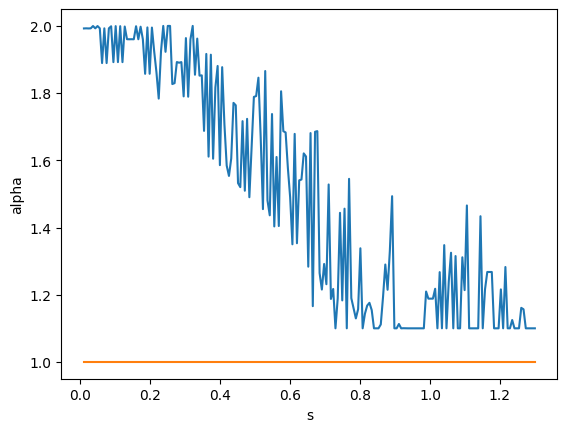

In [14]:
sns.lineplot(df, x="s", y="alpha")
sns.lineplot(df, x="s", y="beta")


<Axes: xlabel='s', ylabel='ks'>

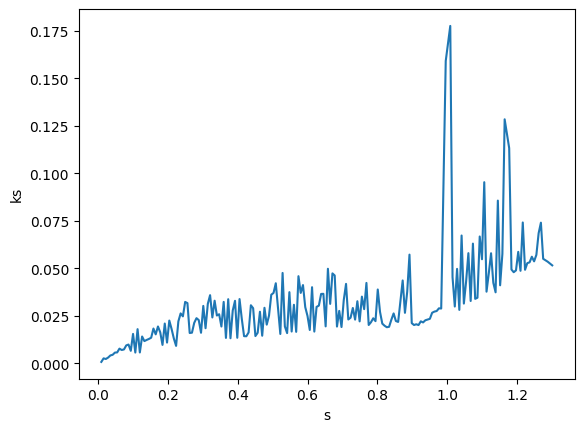

In [19]:
sns.lineplot(df, x="s", y="ks")

In [47]:
s_s = np.linspace(0.01, 1.3, 50)
alphas = np.linspace(1.1, 2.0, 50)
res = []
scores = []
for s in tqdm(s_s):
    for alpha in alphas:
        (ks_x_low, ks_x_high) = sp_lognorm.ppf([1e-4, 1-1e-4], scale=1.0, s=s)
        ks_xs = np.linspace(ks_x_low, ks_x_high, 100)
        ks_cdfs = sp_lognorm.cdf(ks_xs, scale=1.0, s=s)
        
        p = levy_stable_jax.estimation.fit_ks(ks_xs, ks_cdfs,param="N1",alpha=alpha,beta=None)
        p = [x.item() for x in p]
        scores.append(ks_score(s, *p))
        res.append(p)

  0%|                                                                                        | 0/50 [00:00<?, ?it/s]

start [ 1.9925027  -0.          1.0003159   0.00708785]
res [1.1000000e+00 2.4906540e-06 1.0000191e+00 5.2843387e-03]
start [ 1.9925027  -0.          1.0003159   0.00708785]
res [1.1183673e+00 9.9803028e-06 1.0000213e+00 5.3357719e-03]
start [ 1.9925027  -0.          1.0003159   0.00708785]
res [1.1367347e+00 9.6389404e-06 1.0000188e+00 5.3825025e-03]
start [ 1.9925027  -0.          1.0003159   0.00708785]
res [1.1551020e+00 9.1342063e-06 1.0000187e+00 5.4303911e-03]
start [ 1.9925027  -0.          1.0003159   0.00708785]
res [1.1734694e+00 9.2036917e-06 1.0000176e+00 5.4146284e-03]
start [ 1.9925027  -0.          1.0003159   0.00708785]
res [1.1918367e+00 3.3729759e-06 1.0000635e+00 5.5612628e-03]
start [ 1.9925027  -0.          1.0003159   0.00708785]
res [ 1.2102041e+00 -8.4846115e-06  1.0000106e+00  5.5612610e-03]
start [ 1.9925027  -0.          1.0003159   0.00708785]
res [ 1.2285714e+00 -7.5154344e-06  1.0000089e+00  5.5652424e-03]
start [ 1.9925027  -0.          1.0003159   0.00

  2%|█▌                                                                           | 1/50 [06:43<5:29:35, 403.57s/it]

res [2.         0.         1.0000324  0.00705687]
start [ 1.9925027  -0.          1.0022959   0.02582016]
res [ 1.1000000e+00 -3.6783429e-05  1.0001568e+00  1.9095518e-02]
start [ 1.9925027  -0.          1.0022959   0.02582016]
res [ 1.1183673e+00 -1.1134887e-05  1.0002501e+00  1.9354271e-02]
start [ 1.9925027  -0.          1.0022959   0.02582016]
res [ 1.1367347e+00 -4.0327518e-06  1.0003086e+00  1.9570516e-02]
start [ 1.9925027  -0.          1.0022959   0.02582016]
res [ 1.1551020e+00 -3.8316164e-05  1.0001234e+00  1.9552696e-02]
start [ 1.9925027  -0.          1.0022959   0.02582016]
res [ 1.1734694e+00 -3.1732881e-05  1.0001440e+00  1.9714691e-02]
start [ 1.9925027  -0.          1.0022959   0.02582016]
res [ 1.1918367e+00 -3.1450283e-05  1.0001481e+00  1.9860664e-02]
start [ 1.9925027  -0.          1.0022959   0.02582016]
res [1.2102041e+00 5.5255776e-05 1.0001659e+00 2.0014357e-02]
start [ 1.9925027  -0.          1.0022959   0.02582016]
res [1.2285714e+00 4.1552310e-05 1.0001215e+

  4%|███                                                                          | 2/50 [12:46<5:03:49, 379.78s/it]

res [2.         0.         1.0003794  0.02561107]
start [1.889201   0.9397674  0.9983588  0.04199382]
res [1.1        0.8979104  1.1533282  0.03183406]
start [1.889201   0.9397674  0.9983588  0.04199382]
res [1.1183673  0.8982842  1.1198494  0.03016317]
start [1.889201   0.9397674  0.9983588  0.04199382]
res [1.1367347  0.898291   1.1021391  0.03054585]
start [1.889201   0.9397674  0.9983588  0.04199382]
res [1.155102  0.8982602 1.0893857 0.0313524]
start [1.889201   0.9397674  0.9983588  0.04199382]
res [1.1734694  0.89876324 1.0738688  0.03008873]
start [1.889201   0.9397674  0.9983588  0.04199382]
res [1.1918367  0.8988226  1.068897   0.03159716]
start [1.889201   0.9397674  0.9983588  0.04199382]
res [1.2102041  0.8988821  1.0616992  0.03188202]
start [1.889201   0.9397674  0.9983588  0.04199382]
res [1.2285714  0.8989415  1.055665   0.03219274]
start [1.889201   0.9397674  0.9983588  0.04199382]
res [1.2469388  0.8989673  1.0507137  0.03267751]
start [1.889201   0.9397674  0.99835

  6%|████▌                                                                        | 3/50 [19:40<5:09:39, 395.31s/it]

res [2.         0.9        1.0011207  0.04417173]
start [2.         1.         1.0041953  0.06422513]
res [1.1        0.89642155 1.2062349  0.04260159]
start [2.         1.         1.0041953  0.06422513]
res [1.1183673  0.8965747  1.1701535  0.04276703]
start [2.         1.         1.0041953  0.06422513]
res [1.1367347  0.8964104  1.1453211  0.04345925]
start [2.         1.         1.0041953  0.06422513]
res [1.155102   0.8967748  1.1360058  0.04550432]
start [2.         1.         1.0041953  0.06422513]
res [1.1734694  0.89694476 1.1157689  0.04522694]
start [2.         1.         1.0041953  0.06422513]
res [1.1918367  0.89741516 1.0980419  0.04475606]
start [2.         1.         1.0041953  0.06422513]
res [1.2102041  0.89753145 1.0879271  0.04524549]
start [2.         1.         1.0041953  0.06422513]
res [1.2285714  0.89763796 1.079454   0.04573777]
start [2.         1.         1.0041953  0.06422513]
res [1.2469388  0.89775485 1.0725411  0.04625205]
start [2.         1.         1.0

  8%|██████▏                                                                      | 4/50 [25:37<4:51:23, 380.08s/it]

res [2.         0.9        1.0022224  0.06269053]
start [2.         1.         1.0085177  0.08425569]
res [1.1        0.893991   1.2795504  0.05794334]
start [2.         1.         1.0085177  0.08425569]
res [1.1183673  0.89448947 1.2170057  0.054685  ]
start [2.         1.         1.0085177  0.08425569]
res [1.1367347  0.8945308  1.1879121  0.05610527]
start [2.         1.         1.0085177  0.08425569]
res [1.155102   0.8947828  1.1656766  0.05788447]
start [2.         1.         1.0085177  0.08425569]
res [1.1734694  0.8949474  1.1433797  0.05738201]
start [2.         1.         1.0085177  0.08425569]
res [1.1918367  0.8953107  1.127639   0.05803073]
start [2.         1.         1.0085177  0.08425569]
res [1.2102041  0.89551103 1.1133904  0.058242  ]
start [2.         1.         1.0085177  0.08425569]
res [1.2285714  0.89572316 1.1034297  0.05924608]
start [2.         1.         1.0085177  0.08425569]
res [1.2469388  0.8959074  1.0942465  0.06000868]
start [2.         1.         1.0

 10%|███████▋                                                                     | 5/50 [31:53<4:44:08, 378.86s/it]

res [2.         0.9        1.0037408  0.08124433]
start [1.9606441  1.         1.000218   0.09899055]
res [1.1        0.89213246 1.3260455  0.06725409]
start [1.9606441  1.         1.000218   0.09899055]
res [1.1183673  0.89283377 1.2711712  0.06804403]
start [1.9606441  1.         1.000218   0.09899055]
res [1.1367347  0.8930155  1.2309941  0.06883357]
start [1.9606441  1.         1.000218   0.09899055]
res [1.155102   0.8844848  1.1986401  0.06966272]
start [1.9606441  1.         1.000218   0.09899055]
res [1.1734694  0.8927342  1.1765032  0.07046068]
start [1.9606441  1.         1.000218   0.09899055]
res [1.1918367 0.8944918 1.1573774 0.0712501]
start [1.9606441  1.         1.000218   0.09899055]
res [1.2102041  0.89481425 1.1411042  0.07193211]
start [1.9606441  1.         1.000218   0.09899055]
res [1.2285714  0.89503753 1.1277914  0.07274708]
start [1.9606441  1.         1.000218   0.09899055]
res [1.2469388  0.8953537  1.1166676  0.07380415]
start [1.9606441  1.         1.00021

 12%|█████████▏                                                                   | 6/50 [38:11<4:37:30, 378.41s/it]

res [2.         0.9        1.0056453  0.09978048]
start [1.9606441  1.         1.0033947  0.11956879]
res [1.1        0.8903168  1.3887366  0.08004214]
start [1.9606441  1.         1.0033947  0.11956879]
res [1.1183673  0.890176   1.3229887  0.08106558]
start [1.9606441  1.         1.0033947  0.11956879]
res [1.1367347  0.8910782  1.2764808  0.08235918]
start [1.9606441  1.         1.0033947  0.11956879]
res [1.155102  0.8914999 1.2396587 0.0831592]
start [1.9606441  1.         1.0033947  0.11956879]
res [1.1734694  0.8917167  1.2103294  0.08379174]
start [1.9606441  1.         1.0033947  0.11956879]
res [1.1918367  0.89180255 1.1871172  0.08453324]
start [1.9606441  1.         1.0033947  0.11956879]
res [1.2102041  0.8922736  1.1687679  0.08582361]
start [1.9606441  1.         1.0033947  0.11956879]
res [1.2285714  0.8926328  1.1526495  0.08663129]
start [1.9606441  1.         1.0033947  0.11956879]
res [1.2469388  0.8926045  1.13865    0.08717768]
start [1.9606441  1.         1.00339

 14%|██████████▊                                                                  | 7/50 [44:12<4:27:07, 372.72s/it]

res [2.         0.9        1.0078864  0.11830124]
start [2.         1.         1.0102353  0.14167301]
res [1.1        0.88714284 1.4153901  0.08662485]
start [2.         1.         1.0102353  0.14167301]
res [1.1183673  0.88775826 1.3486127  0.08837381]
start [2.         1.         1.0102353  0.14167301]
res [1.1367347  0.88817275 1.3194121  0.09506956]
start [2.         1.         1.0102353  0.14167301]
res [1.155102   0.8889868  1.2680157  0.09343573]
start [2.         1.         1.0102353  0.14167301]
res [1.1734694  0.8895276  1.2381301  0.09518223]
start [2.         1.         1.0102353  0.14167301]
res [1.1918367  0.89018995 1.2173508  0.09794313]
start [2.         1.         1.0102353  0.14167301]
res [1.2102041  0.89068824 1.1956276  0.09899274]
start [2.         1.         1.0102353  0.14167301]
res [1.2285714  0.8910796  1.1779299  0.10057285]
start [2.         1.         1.0102353  0.14167301]
res [1.2469388  0.8911785  1.1615764  0.10104501]
start [2.         1.         1.0

 16%|████████████▎                                                                | 8/50 [49:57<4:14:41, 363.84s/it]

res [2.         0.9        1.01044    0.13657615]
start [1.924      1.         1.0061654  0.15432166]
res [1.1        0.88497216 1.5002985  0.10342236]
start [1.924      1.         1.0061654  0.15432166]
res [1.1183673  0.884014   1.4138447  0.10421458]
start [1.924      1.         1.0061654  0.15432166]
res [1.1367347  0.8846203  1.3535298  0.10555308]
start [1.924      1.         1.0061654  0.15432166]
res [1.155102   0.8853629  1.3142666  0.10875979]
start [1.924      1.         1.0061654  0.15432166]
res [1.1734694  0.8860979  1.2702844  0.10781673]
start [1.924      1.         1.0061654  0.15432166]
res [1.1918367  0.8864769  1.2426045  0.10958672]
start [1.924      1.         1.0061654  0.15432166]
res [1.2102041  0.8869352  1.2197683  0.11130363]
start [1.924      1.         1.0061654  0.15432166]
res [1.2285714  0.8875177  1.2019632  0.11358436]
start [1.924      1.         1.0061654  0.15432166]
res [1.2469388  0.8906348  1.1841072  0.11442772]
start [1.924      1.         1.0

 18%|█████████████▊                                                               | 9/50 [55:35<4:03:03, 355.70s/it]

res [2.         0.9        1.0137749  0.15456076]
start [1.8257179  1.         0.9983554  0.16445583]
res [1.1        0.88195133 1.5714698  0.11805701]
start [1.8257179  1.         0.9983554  0.16445583]
res [1.1183673  0.88370717 1.474477   0.11877975]
start [1.8257179  1.         0.9983554  0.16445583]
res [1.1367347  0.88389474 1.406751   0.12076224]
start [1.8257179  1.         0.9983554  0.16445583]
res [1.155102  0.8854782 1.352378  0.1214374]
start [1.8257179  1.         0.9983554  0.16445583]
res [1.1734694  0.8855642  1.310759   0.12280624]
start [1.8257179  1.         0.9983554  0.16445583]
res [1.1918367  0.88653463 1.2777148  0.124204  ]
start [1.8257179  1.         0.9983554  0.16445583]
res [1.2102041  0.8871943  1.2504293  0.12558779]
start [1.8257179  1.         0.9983554  0.16445583]
res [1.2285714  0.8876586  1.227325   0.12690805]
start [1.8257179  1.         0.9983554  0.16445583]
res [1.2469388  0.88836575 1.2081254  0.1287704 ]
start [1.8257179  1.         0.99835

 20%|██████████████▊                                                           | 10/50 [1:01:12<3:53:24, 350.10s/it]

res [2.        0.9       1.0169257 0.1735789]
start [1.8923334  1.         1.003782   0.18917422]
res [1.1        0.87932456 1.630249   0.13023068]
start [1.8923334  1.         1.003782   0.18917422]
res [1.1183673  0.88219225 1.519804   0.1302502 ]
start [1.8923334  1.         1.003782   0.18917422]
res [1.1367347  0.8806265  1.4492316  0.13331725]
start [1.8923334  1.         1.003782   0.18917422]
res [1.155102  0.883901  1.392038  0.1349031]
start [1.8923334  1.         1.003782   0.18917422]
res [1.1734694  0.8841196  1.3459685  0.13633768]
start [1.8923334  1.         1.003782   0.18917422]
res [1.1918367  0.88515973 1.3093467  0.13787378]
start [1.8923334  1.         1.003782   0.18917422]
res [1.2102041  0.88606447 1.2819965  0.1415489 ]
start [1.8923334  1.         1.003782   0.18917422]
res [1.2285714  0.88621175 1.2530963  0.14076228]
start [1.8923334  1.         1.003782   0.18917422]
res [1.2469388 0.8880487 1.2449155 0.1449867]
start [1.8923334  1.         1.003782   0.18

 22%|████████████████▎                                                         | 11/50 [1:06:42<3:43:34, 343.97s/it]

res [2.         0.9        1.020714   0.19190066]
start [1.96553    1.         1.0100229  0.21540383]
res [1.1        0.8794578  1.696542   0.14313237]
start [1.96553    1.         1.0100229  0.21540383]
res [1.1183673  0.8800518  1.5794985  0.14498591]
start [1.96553    1.         1.0100229  0.21540383]
res [1.1367347  0.8810809  1.495235   0.14652427]
start [1.96553    1.         1.0100229  0.21540383]
res [1.155102   0.88105047 1.4297917  0.14753693]
start [1.96553    1.         1.0100229  0.21540383]
res [1.1734694  0.88307816 1.3814887  0.149737  ]
start [1.96553    1.         1.0100229  0.21540383]
res [1.1918367 0.8835766 1.339972  0.1508282]
start [1.96553    1.         1.0100229  0.21540383]
res [1.2102041  0.8855554  1.3096519  0.15443386]
start [1.96553    1.         1.0100229  0.21540383]
res [1.2285714  0.8867     1.2788665  0.15404387]
start [1.96553    1.         1.0100229  0.21540383]
res [1.2469388  0.88737303 1.2550945  0.15578985]
start [1.96553    1.         1.01002

 24%|█████████████████▊                                                        | 12/50 [1:11:57<3:32:15, 335.14s/it]

res [2.         0.9        1.0254335  0.20773599]
start [1.8561429 1.        0.9890213 0.2241479]
res [1.1        0.8810628  1.7539884  0.15469725]
start [1.8561429 1.        0.9890213 0.2241479]
res [1.1183673  0.8808839  1.6303954  0.15691847]
start [1.8561429 1.        0.9890213 0.2241479]
res [1.1367347  0.8820139  1.5399511  0.15862903]
start [1.8561429 1.        0.9890213 0.2241479]
res [1.155102   0.8843875  1.4709362  0.16031983]
start [1.8561429 1.        0.9890213 0.2241479]
res [1.1734694  0.88403267 1.4172102  0.16287822]
start [1.8561429 1.        0.9890213 0.2241479]
res [1.1918367  0.8846822  1.371296   0.16378513]
start [1.8561429 1.        0.9890213 0.2241479]
res [1.2102041  0.88634795 1.3349293  0.16539851]
start [1.8561429 1.        0.9890213 0.2241479]
res [1.2285714  0.9        1.3084807  0.16698049]
start [1.8561429 1.        0.9890213 0.2241479]
res [1.2469388  0.8881601  1.2827896  0.16981944]
start [1.8561429 1.        0.9890213 0.2241479]
res [1.2653061  0.9 

 26%|███████████████████▏                                                      | 13/50 [1:17:32<3:26:40, 335.15s/it]

res [2.         0.9        1.0291538  0.22835635]
start [1.924      1.         1.0211326  0.25337955]
res [1.1        0.87413794 1.7701766  0.1599579 ]
start [1.924      1.         1.0211326  0.25337955]
res [1.1183673  0.87500626 1.6803021  0.16970418]
start [1.924      1.         1.0211326  0.25337955]
res [1.1367347  0.8790776  1.5893097  0.17365696]
start [1.924      1.         1.0211326  0.25337955]
res [1.155102   0.87902015 1.5080155  0.17350607]
start [1.924      1.         1.0211326  0.25337955]
res [1.1734694  0.8835788  1.4493172  0.17472418]
start [1.924      1.         1.0211326  0.25337955]
res [1.1918367  0.88448304 1.4035261  0.17711666]
start [1.924      1.         1.0211326  0.25337955]
res [1.2102041  0.88638985 1.3650936  0.17908098]
start [1.924      1.         1.0211326  0.25337955]
res [1.2285714  0.89119303 1.3336781  0.18090178]
start [1.924      1.         1.0211326  0.25337955]
res [1.2469388  0.89158756 1.3058465  0.18284945]
start [1.924      1.         1.0

 28%|████████████████████▋                                                     | 14/50 [1:22:58<3:19:21, 332.27s/it]

res [2.         0.9        1.0342876  0.24603616]
start [1.8160045  1.         0.9914755  0.25972584]
res [1.1        0.8769076  1.8572414  0.17639095]
start [1.8160045  1.         0.9914755  0.25972584]
res [1.1183673  0.8773619  1.7335286  0.18225414]
start [1.8160045  1.         0.9914755  0.25972584]
res [1.1367347  0.9        1.6409831  0.18371704]
start [1.8160045  1.         0.9914755  0.25972584]
res [1.155102   0.8760437  1.5475824  0.18666245]
start [1.8160045  1.         0.9914755  0.25972584]
res [1.1734694  0.8829305  1.4886212  0.18911779]
start [1.8160045  1.         0.9914755  0.25972584]
res [1.1918367  0.8848421  1.4372044  0.19077641]
start [1.8160045  1.         0.9914755  0.25972584]
res [1.2102041  0.9        1.3995494  0.19222374]
start [1.8160045  1.         0.9914755  0.25972584]
res [1.2285714  0.88137275 1.357578   0.19481315]
start [1.8160045  1.         0.9914755  0.25972584]
res [1.2469388  0.8862581  1.3293093  0.19680819]
start [1.8160045  1.         0.9

 30%|██████████████████████▏                                                   | 15/50 [1:28:23<3:12:31, 330.04s/it]

res [2.         0.9        1.0400431  0.26177272]
start [1.8874615  1.         0.9802293  0.29248187]
res [1.1        0.88136244 1.9471775  0.19279692]
start [1.8874615  1.         0.9802293  0.29248187]
res [1.1183673  0.8837156  1.7933431  0.19505684]
start [1.8874615  1.         0.9802293  0.29248187]
res [1.1367347  0.9        1.6890354  0.19678052]
start [1.8874615  1.         0.9802293  0.29248187]
res [1.155102   0.9        1.6005634  0.19899532]
start [1.8874615  1.         0.9802293  0.29248187]
res [1.1734694  0.8873246  1.5255413  0.20167217]
start [1.8874615  1.         0.9802293  0.29248187]
res [1.1918367  0.8859106  1.4820613  0.21150011]
start [1.8874615  1.         0.9802293  0.29248187]
res [1.2102041  0.88803804 1.4303294  0.20984907]
start [1.8874615  1.         0.9802293  0.29248187]
res [1.2285714  0.88824695 1.3946435  0.21466798]
start [1.8874615  1.         0.9802293  0.29248187]
res [1.2469388  0.8894538  1.3607472  0.21565479]
start [1.8874615  1.         0.9

 32%|███████████████████████▋                                                  | 16/50 [1:33:41<3:04:58, 326.43s/it]

res [2.         0.9        1.0446675  0.28229022]
start [1.773      1.         0.97951126 0.2953471 ]
res [1.1        0.87802875 2.007483   0.20540322]
start [1.773      1.         0.97951126 0.2953471 ]
res [1.1183673  0.8793071  1.8667881  0.21480417]
start [1.773      1.         0.97951126 0.2953471 ]
res [1.1367347  0.8803129  1.74205    0.21701652]
start [1.773      1.         0.97951126 0.2953471 ]
res [1.155102   0.8828566  1.6339116  0.21287195]
start [1.773      1.         0.97951126 0.2953471 ]
res [1.1734694  0.88414466 1.562055   0.21525404]
start [1.773      1.         0.97951126 0.2953471 ]
res [1.1918367  0.9        1.5101885  0.21712387]
start [1.773      1.         0.97951126 0.2953471 ]
res [1.2102041  0.88626236 1.4555857  0.2198815 ]
start [1.773      1.         0.97951126 0.2953471 ]
res [1.2285714 0.8826294 1.4143491 0.2224901]
start [1.773      1.         0.97951126 0.2953471 ]
res [1.2469388  0.88862956 1.3823385  0.22536604]
start [1.773      1.         0.97951

 34%|█████████████████████████▏                                                | 17/50 [1:39:46<3:05:54, 338.00s/it]

res [2.         0.9        1.0575613  0.26177415]
start [1.8448334  1.         1.0069864  0.33197755]
res [1.1        0.88035756 2.0687287  0.21694016]
start [1.8448334  1.         1.0069864  0.33197755]
res [1.1183673  0.87756026 1.8954914  0.22045138]
start [1.8448334  1.         1.0069864  0.33197755]
res [1.1367347  0.8811777  1.7704467  0.22295858]
start [1.8448334  1.         1.0069864  0.33197755]
res [1.155102   0.88012445 1.67276    0.22572891]
start [1.8448334  1.         1.0069864  0.33197755]
res [1.1734694  0.886694   1.5996315  0.22805999]
start [1.8448334  1.         1.0069864  0.33197755]
res [1.1918367  0.8865703  1.5398519  0.23210403]
start [1.8448334  1.         1.0069864  0.33197755]
res [1.2102041  0.8871348  1.4874219  0.23334152]
start [1.8448334  1.         1.0069864  0.33197755]
res [1.2285714  0.8880483  1.4449296  0.23588201]
start [1.8448334  1.         1.0069864  0.33197755]
res [1.2469388  0.8939553  1.4046512  0.23551922]
start [1.8448334  1.         1.0

 36%|██████████████████████████▋                                               | 18/50 [1:45:14<2:58:44, 335.14s/it]

res [2.         0.9        1.0608673  0.30406645]
start [1.7243637  1.         1.0018643  0.33051124]
res [1.1        0.8766637  2.1324089  0.22998397]
start [1.7243637  1.         1.0018643  0.33051124]
res [1.1183673  0.9        1.9684838  0.23198313]
start [1.7243637  1.         1.0018643  0.33051124]
res [1.1367347 0.8987378 1.88449   0.2441601]
start [1.7243637  1.         1.0018643  0.33051124]
res [1.155102   0.9        1.7340722  0.24110097]
start [1.7243637  1.         1.0018643  0.33051124]
res [1.1734694  0.89890414 1.6433377  0.2404089 ]
start [1.7243637  1.         1.0018643  0.33051124]
res [1.1918367  0.9        1.5903227  0.24589035]
start [1.7243637  1.         1.0018643  0.33051124]
res [1.2102041  0.9        1.5270782  0.24681565]
start [1.7243637  1.         1.0018643  0.33051124]
res [1.2285714  0.89488906 1.5151789  0.28000623]
start [1.7243637  1.         1.0018643  0.33051124]
res [1.2469388  0.8951357  1.4705904  0.28281116]
start [1.7243637  1.         1.00186

 38%|████████████████████████████                                              | 19/50 [1:50:20<2:48:38, 326.40s/it]

res [2.         0.9        1.0710784  0.29332379]
start [1.8808181  1.         0.97764987 0.37608227]
res [1.1        0.88800764 2.2100878  0.24193516]
start [1.8808181  1.         0.97764987 0.37608227]
res [1.1183673  0.8890207  2.0138493  0.24481846]
start [1.8808181  1.         0.97764987 0.37608227]
res [1.1367347  0.8898685  1.8734975  0.24850397]
start [1.8808181  1.         0.97764987 0.37608227]
res [1.155102   0.8921107  1.7886734  0.26157755]
start [1.8808181  1.         0.97764987 0.37608227]
res [1.1734694  0.891037   1.6809719  0.25583386]
start [1.8808181  1.         0.97764987 0.37608227]
res [1.1918367  0.88860965 1.5994079  0.254627  ]
start [1.8808181  1.         0.97764987 0.37608227]
res [1.2102041  0.8934273  1.554396   0.26161736]
start [1.8808181  1.         0.97764987 0.37608227]
res [1.2285714  0.8945892  1.5072584  0.26362404]
start [1.8808181  1.         0.97764987 0.37608227]
res [1.2469388  0.8942273  1.4673762  0.26891497]
start [1.8808181  1.         0.9

 40%|█████████████████████████████▌                                            | 20/50 [1:55:49<2:43:30, 327.00s/it]

res [2.         0.9        1.0755087  0.32845056]
start [1.6731429  1.         0.94060594 0.364221  ]
res [1.1        0.8972803  2.299022   0.25725397]
start [1.6731429  1.         0.94060594 0.364221  ]
res [1.1183673  0.8998598  2.0821133  0.25786245]
start [1.6731429  1.         0.94060594 0.364221  ]
res [1.1367347  0.9        1.9260647  0.26007038]
start [1.6731429  1.         0.94060594 0.364221  ]
res [1.155102   0.9        1.8210552  0.26710296]
start [1.6731429  1.         0.94060594 0.364221  ]
res [1.1734694  0.9        1.72387    0.26766086]
start [1.6731429  1.         0.94060594 0.364221  ]
res [1.1918367  0.9        1.649663   0.27066967]
start [1.6731429  1.         0.94060594 0.364221  ]
res [1.2102041 0.9       1.5890585 0.2738311]
start [1.6731429  1.         0.94060594 0.364221  ]
res [1.2285714 0.9       1.5389452 0.2771242]
start [1.6731429  1.         0.94060594 0.364221  ]
res [1.2469388  0.9        1.4966055  0.28076807]
start [1.6731429  1.         0.94060594 

 42%|███████████████████████████████                                           | 21/50 [2:01:48<2:42:45, 336.74s/it]

res [2.         0.9        1.0805413  0.35803804]
start [1.829     1.        0.9668014 0.4160355]
res [1.1       0.8930268 2.3572907 0.2692453]
start [1.829     1.        0.9668014 0.4160355]
res [1.1183673  0.8938565  2.1314137  0.27030265]
start [1.829     1.        0.9668014 0.4160355]
res [1.1367347 0.9       1.9791455 0.2737105]
start [1.829     1.        0.9668014 0.4160355]
res [1.155102   0.89046746 1.8561685  0.27972126]
start [1.829     1.        0.9668014 0.4160355]
res [1.1734694  0.897718   1.7659407  0.28313756]
start [1.829     1.        0.9668014 0.4160355]
res [1.1918367  0.8981643  1.6860904  0.28501412]
start [1.829     1.        0.9668014 0.4160355]
res [1.2102041  0.89500946 1.620629   0.28991374]
start [1.829     1.        0.9668014 0.4160355]
res [1.2285714  0.8958769  1.5624603  0.28956184]
start [1.829     1.        0.9668014 0.4160355]
res [1.2469388  0.9        1.5264885  0.29589787]
start [1.829     1.        0.9668014 0.4160355]
res [1.2653061 0.8957489 1.4

 44%|████████████████████████████████▌                                         | 22/50 [2:07:09<2:34:53, 331.89s/it]

res [2.         0.9        1.0903531  0.35648108]
start [1.6178974  1.         0.91620845 0.39503244]
res [1.1        0.9        2.42301    0.27917364]
start [1.6178974  1.         0.91620845 0.39503244]
res [1.1183673  0.9        2.1960747  0.28312558]
start [1.6178974  1.         0.91620845 0.39503244]
res [1.1367347 0.9       2.0306466 0.2871015]
start [1.6178974  1.         0.91620845 0.39503244]
res [1.155102   0.9        1.904761   0.29103854]
start [1.6178974  1.         0.91620845 0.39503244]
res [1.1734694  0.9        1.8390698  0.31338593]
start [1.6178974  1.         0.91620845 0.39503244]
res [1.1918367 0.9       1.7255144 0.2992133]
start [1.6178974  1.         0.91620845 0.39503244]
res [1.2102041  0.9        1.6762106  0.31782773]
start [1.6178974  1.         0.91620845 0.39503244]
res [1.2285714  0.9        1.6035116  0.30647227]
start [1.6178974  1.         0.91620845 0.39503244]
res [1.2469388  0.9        1.5618963  0.31919518]
start [1.6178974  1.         0.91620845 

 46%|██████████████████████████████████                                        | 23/50 [2:12:37<2:28:55, 330.93s/it]

res [2.         0.9        1.0980881  0.37669584]
start [1.773      1.         1.0250585  0.45341352]
res [1.1        0.89281297 2.483686   0.2924104 ]
start [1.773      1.         1.0250585  0.45341352]
res [1.1183673  0.9        2.2546997  0.29595965]
start [1.773      1.         1.0250585  0.45341352]
res [1.1367347  0.89344907 2.0777607  0.30114204]
start [1.773      1.         1.0250585  0.45341352]
res [1.155102   0.89811146 1.9509115  0.30573913]
start [1.773      1.         1.0250585  0.45341352]
res [1.1734694 0.8975051 1.8496201 0.3102469]
start [1.773      1.         1.0250585  0.45341352]
res [1.1918367  0.8983966  1.7629385  0.31357315]
start [1.773      1.         1.0250585  0.45341352]
res [1.2102041 0.8975644 1.6992059 0.3236296]
start [1.773      1.         1.0250585  0.45341352]
res [1.2285714  0.8979642  1.6362873  0.32217556]
start [1.773      1.         1.0250585  0.45341352]
res [1.2469388  0.89909625 1.5860525  0.32549182]
start [1.773      1.         1.0250585  

 48%|███████████████████████████████████▌                                      | 24/50 [2:17:34<2:18:53, 320.53s/it]

res [2.         0.9        1.107109   0.38122833]
start [1.6271223  1.         0.97915    0.42993706]
res [1.1        0.89729303 2.5623279  0.30569926]
start [1.6271223  1.         0.97915    0.42993706]
res [1.1183673  0.9        2.3140938  0.30918726]
start [1.6271223  1.         0.97915    0.42993706]
res [1.1367347 0.8994781 2.1790304 0.3307376]
start [1.6271223  1.         0.97915    0.42993706]
res [1.155102   0.8993706  2.031927   0.33493298]
start [1.6271223  1.         0.97915    0.42993706]
res [1.1734694  0.8993269  1.9143006  0.33807585]
start [1.6271223  1.         0.97915    0.42993706]
res [1.1918367  0.89923936 1.8202977  0.34171873]
start [1.6271223  1.         0.97915    0.42993706]
res [1.2102041  0.8992696  1.7451241  0.34692892]
start [1.6271223  1.         0.97915    0.42993706]
res [1.2285714  0.9        1.6716685  0.33754945]
start [1.6271223  1.         0.97915    0.42993706]
res [1.2469388 0.9       1.6210595 0.3425271]
start [1.6271223  1.         0.97915    

 50%|█████████████████████████████████████                                     | 25/50 [2:22:34<2:11:02, 314.50s/it]

res [2.         0.9        1.1171614  0.38704395]
start [1.7105     1.         0.96222204 0.4856599 ]
res [1.1        0.9        2.6332076  0.31807658]
start [1.7105     1.         0.96222204 0.4856599 ]
res [1.1183673 0.8986532 2.3615298 0.3203581]
start [1.7105     1.         0.96222204 0.4856599 ]
res [1.1367347  0.9        2.191379   0.32851183]
start [1.7105     1.         0.96222204 0.4856599 ]
res [1.155102   0.89604485 2.0439112  0.3335438 ]
start [1.7105     1.         0.96222204 0.4856599 ]
res [1.1734694  0.89701366 1.9327242  0.3389334 ]
start [1.7105     1.         0.96222204 0.4856599 ]
res [1.1918367  0.89822906 1.8426286  0.34308073]
start [1.7105     1.         0.96222204 0.4856599 ]
res [1.2102041  0.8977398  1.7711341  0.35268092]
start [1.7105     1.         0.96222204 0.4856599 ]
res [1.2285714  0.8990506  1.7177436  0.35678065]
start [1.7105     1.         0.96222204 0.4856599 ]
res [1.2469388  0.8977694  1.6443838  0.36015478]
start [1.7105     1.         0.96222

 52%|██████████████████████████████████████▍                                   | 26/50 [2:27:32<2:03:45, 309.40s/it]

res [2.         0.9        1.12409    0.40144455]
start [1.4746623 1.        0.8772172 0.4347625]
res [1.1        0.9        2.73889    0.33930492]
start [1.4746623 1.        0.8772172 0.4347625]
res [1.1183673  0.9        2.4501398  0.34010214]
start [1.4746623 1.        0.8772172 0.4347625]
res [1.1367347  0.9        2.2440603  0.34210673]
start [1.4746623 1.        0.8772172 0.4347625]
res [1.155102  0.9       2.0964234 0.3475041]
start [1.4746623 1.        0.8772172 0.4347625]
res [1.1734694 0.9       1.9816117 0.3546067]
start [1.4746623 1.        0.8772172 0.4347625]
res [1.1918367  0.9        1.8854973  0.35853022]
start [1.4746623 1.        0.8772172 0.4347625]
res [1.2102041 0.9       1.8083041 0.3640853]
start [1.4746623 1.        0.8772172 0.4347625]
res [1.2285714  0.9        1.7372113  0.36697072]
start [1.4746623 1.        0.8772172 0.4347625]
res [1.2469388  0.9        1.6764233  0.36926648]
start [1.4746623 1.        0.8772172 0.4347625]
res [1.2653061 0.9       1.62266

 54%|███████████████████████████████████████▉                                  | 27/50 [2:32:32<1:57:32, 306.61s/it]

res [2.         0.9        1.13364    0.44064245]
start [1.6391429 1.        0.988323  0.5082311]
res [1.1       0.9       2.7830234 0.3456462]
start [1.6391429 1.        0.988323  0.5082311]
res [1.1183673  0.9        2.5038743  0.35093817]
start [1.6391429 1.        0.988323  0.5082311]
res [1.1367347 0.9       2.3065848 0.3590437]
start [1.6391429 1.        0.988323  0.5082311]
res [1.155102  0.9       2.1453276 0.3614212]
start [1.6391429 1.        0.988323  0.5082311]
res [1.1734694  0.9        1.9935386  0.35742736]
start [1.6391429 1.        0.988323  0.5082311]
res [1.1918367 0.9       1.9345734 0.3758241]
start [1.6391429 1.        0.988323  0.5082311]
res [1.2102041 0.9       1.8363262 0.3756191]
start [1.6391429 1.        0.988323  0.5082311]
res [1.2285714  0.9        1.7651427  0.37961152]
start [1.6391429 1.        0.988323  0.5082311]
res [1.2469388  0.9        1.7006181  0.38161334]
start [1.6391429 1.        0.988323  0.5082311]
res [1.2653061 0.8998494 1.6414456 0.381

 56%|█████████████████████████████████████████▍                                | 28/50 [2:37:21<1:50:29, 301.33s/it]

res [2.         0.9        1.142858   0.41793844]
start [1.4612105  1.         0.89708376 0.45140827]
res [1.1        0.9        2.9356346  0.37790906]
start [1.4612105  1.         0.89708376 0.45140827]
res [1.1183673  0.9        2.591701   0.36910364]
start [1.4612105  1.         0.89708376 0.45140827]
res [1.1367347  0.9        2.375314   0.37443376]
start [1.4612105  1.         0.89708376 0.45140827]
res [1.155102   0.9        2.2249146  0.38289964]
start [1.4612105  1.         0.89708376 0.45140827]
res [1.1734694  0.9        2.072512   0.38311407]
start [1.4612105  1.         0.89708376 0.45140827]
res [1.1918367  0.9        1.9691517  0.38852024]
start [1.4612105  1.         0.89708376 0.45140827]
res [1.2102041 0.9       1.8734927 0.3902652]
start [1.4612105  1.         0.89708376 0.45140827]
res [1.2285714 0.9       1.7947282 0.3924507]
start [1.4612105  1.         0.89708376 0.45140827]
res [1.2469388  0.9        1.727855   0.39462975]
start [1.4612105  1.         0.89708376 

 58%|██████████████████████████████████████████▉                               | 29/50 [2:42:23<1:45:32, 301.56s/it]

res [2.         0.9        1.1490395  0.43490347]
start [1.547      1.         0.99538887 0.51521397]
res [1.1        0.9        2.9424427  0.37441888]
start [1.547      1.         0.99538887 0.51521397]
res [1.1183673  0.9        2.6360507  0.37985396]
start [1.547      1.         0.99538887 0.51521397]
res [1.1367347  0.9        2.4211154  0.38732797]
start [1.547      1.         0.99538887 0.51521397]
res [1.155102   0.9        2.2562816  0.39416623]
start [1.547      1.         0.99538887 0.51521397]
res [1.1734694  0.9        2.1338727  0.40244743]
start [1.547      1.         0.99538887 0.51521397]
res [1.1918367  0.9        2.0002613  0.40066105]
start [1.547      1.         0.99538887 0.51521397]
res [1.2102041  0.9        1.902293   0.40244806]
start [1.547      1.         0.99538887 0.51521397]
res [1.2285714  0.9        1.8207989  0.40494177]
start [1.547      1.         0.99538887 0.51521397]
res [1.2469388  0.9        1.7555516  0.40755254]
start [1.547      1.         0.9

 60%|████████████████████████████████████████████▍                             | 30/50 [2:46:56<1:37:38, 292.92s/it]

res [2.        0.9       1.1629776 0.4205113]
start [1.6545    1.        0.9178822 0.5880837]
res [1.1        0.89766246 3.0212216  0.3901647 ]
start [1.6545    1.        0.9178822 0.5880837]
res [1.1183673  0.89669204 2.7028666  0.39527497]
start [1.6545    1.        0.9178822 0.5880837]
res [1.1367347  0.8968589  2.481221   0.40410998]
start [1.6545    1.        0.9178822 0.5880837]
res [1.155102   0.9        2.2986326  0.40656203]
start [1.6545    1.        0.9178822 0.5880837]
res [1.1734694 0.9       2.1538253 0.4103104]
start [1.6545    1.        0.9178822 0.5880837]
res [1.1918367  0.9        2.0364125  0.41383737]
start [1.6545    1.        0.9178822 0.5880837]
res [1.2102041  0.8968076  1.9364324  0.41718417]
start [1.6545    1.        0.9178822 0.5880837]
res [1.2285714 0.9       1.85642   0.4199207]
start [1.6545    1.        0.9178822 0.5880837]
res [1.2469388  0.9        1.7857246  0.42251188]
start [1.6545    1.        0.9178822 0.5880837]
res [1.2653061 0.9       1.72631

 62%|█████████████████████████████████████████████▉                            | 31/50 [2:51:26<1:30:37, 286.16s/it]

res [2.         0.9        1.1678319  0.45134112]
start [1.371647   1.         0.96462405 0.48459852]
res [1.1       0.9       3.1046066 0.4035335]
start [1.371647   1.         0.96462405 0.48459852]
res [1.1183673  0.9        2.7745035  0.40904355]
start [1.371647   1.         0.96462405 0.48459852]
res [1.1367347  0.9        2.528691   0.41370767]
start [1.371647   1.         0.96462405 0.48459852]
res [1.155102   0.9        2.3365834  0.41697803]
start [1.371647   1.         0.96462405 0.48459852]
res [1.1734694 0.9       2.18501   0.4201278]
start [1.371647   1.         0.96462405 0.48459852]
res [1.1918367  0.9        2.0630646  0.42337164]
start [1.371647   1.         0.96462405 0.48459852]
res [1.2102041  0.9        1.922183   0.40934965]
start [1.371647   1.         0.96462405 0.48459852]
res [1.2285714  0.9        1.8815161  0.43076652]
start [1.371647   1.         0.96462405 0.48459852]
res [1.2469388 0.9       1.8113163 0.434471 ]
start [1.371647   1.         0.96462405 0.48

 64%|███████████████████████████████████████████████▎                          | 32/50 [2:56:06<1:25:18, 284.35s/it]

res [2.        0.9       1.1765445 0.45017  ]
start [1.44175    1.         0.8292472  0.55293304]
res [1.1        0.9        3.1744301  0.41670495]
start [1.44175    1.         0.8292472  0.55293304]
res [1.1183673  0.9        2.8092346  0.41725478]
start [1.44175    1.         0.8292472  0.55293304]
res [1.1367347  0.9        2.564514   0.42296126]
start [1.44175    1.         0.8292472  0.55293304]
res [1.155102  0.9       2.3707554 0.4264681]
start [1.44175    1.         0.8292472  0.55293304]
res [1.1734694  0.9        2.2182121  0.42982674]
start [1.44175    1.         0.8292472  0.55293304]
res [1.1918367  0.9        2.094647   0.43321198]
start [1.44175    1.         0.8292472  0.55293304]
res [1.2102041 0.9       1.9771674 0.430052 ]
start [1.44175    1.         0.8292472  0.55293304]
res [1.2285714 0.9       1.9057716 0.4400051]
start [1.44175    1.         0.8292472  0.55293304]
res [1.2469388 0.9       1.832447  0.4430366]
start [1.44175    1.         0.8292472  0.55293304]


 66%|████████████████████████████████████████████████▊                         | 33/50 [3:00:43<1:19:57, 282.22s/it]

res [2.        0.9       1.1835465 0.4288542]
start [1.547      1.         0.9328762  0.63627005]
res [1.1        0.89564955 3.2273319  0.42815885]
start [1.547      1.         0.9328762  0.63627005]
res [1.1183673  0.8953496  2.8558183  0.42959997]
start [1.547      1.         0.9328762  0.63627005]
res [1.1367347  0.9        2.6036818  0.43330753]
start [1.547      1.         0.9328762  0.63627005]
res [1.155102   0.89888895 2.4000545  0.43625137]
start [1.547      1.         0.9328762  0.63627005]
res [1.1734694 0.9       2.303279  0.4541715]
start [1.547      1.         0.9328762  0.63627005]
res [1.1918367  0.9        2.1213536  0.44384494]
start [1.547      1.         0.9328762  0.63627005]
res [1.2102041  0.9        2.05929    0.45932296]
start [1.547      1.         0.9328762  0.63627005]
res [1.2285714  0.9        1.9316711  0.45097947]
start [1.547      1.         0.9328762  0.63627005]
res [1.2469388  0.9        1.84532    0.44804946]
start [1.547      1.         0.9328762  

 68%|██████████████████████████████████████████████████▎                       | 34/50 [3:05:34<1:15:57, 284.82s/it]

res [2.         0.9        1.1869162  0.43546507]
start [1.547      1.         1.0216209  0.70189935]
res [1.1        0.8958623  3.257681   0.43414742]
start [1.547      1.         1.0216209  0.70189935]
res [1.1183673  0.8957078  2.893777   0.43841934]
start [1.547      1.         1.0216209  0.70189935]
res [1.1367347 0.9       2.639933  0.4424848]
start [1.547      1.         1.0216209  0.70189935]
res [1.155102   0.8958594  2.4309313  0.44636518]
start [1.547      1.         1.0216209  0.70189935]
res [1.1734694  0.9        2.2784896  0.45046696]
start [1.547      1.         1.0216209  0.70189935]
res [1.1918367  0.8956117  2.144934   0.45431474]
start [1.547      1.         1.0216209  0.70189935]
res [1.2102041  0.9        2.0405889  0.45702788]
start [1.547      1.         1.0216209  0.70189935]
res [1.2285714  0.9        1.9530523  0.46100253]
start [1.547      1.         1.0216209  0.70189935]
res [1.2469388  0.89714295 1.8779612  0.46543863]
start [1.547      1.         1.02162

 70%|███████████████████████████████████████████████████▊                      | 35/50 [3:10:23<1:11:29, 286.00s/it]

res [2.         0.9        1.2052295  0.50065637]
start [1.3302143  1.         1.1110475  0.56156003]
res [1.1        0.9        3.3288713  0.44440612]
start [1.3302143  1.         1.1110475  0.56156003]
res [1.1183673  0.9        2.9516213  0.44780207]
start [1.3302143  1.         1.1110475  0.56156003]
res [1.1367347 0.9       2.6792812 0.4518624]
start [1.3302143  1.         1.1110475  0.56156003]
res [1.155102  0.9       2.469954  0.4554454]
start [1.3302143  1.         1.1110475  0.56156003]
res [1.1734694  0.9        2.3080916  0.45984128]
start [1.3302143  1.         1.1110475  0.56156003]
res [1.1918367  0.9        2.1780312  0.46414462]
start [1.3302143  1.         1.1110475  0.56156003]
res [1.2102041 0.9       2.070685  0.4684018]
start [1.3302143  1.         1.1110475  0.56156003]
res [1.2285714  0.9        1.9797568  0.47224894]
start [1.3302143  1.         1.1110475  0.56156003]
res [1.2469388  0.9        1.8158653  0.43245018]
start [1.3302143  1.         1.1110475  0.56

 72%|█████████████████████████████████████████████████████▎                    | 36/50 [3:14:53<1:05:38, 281.33s/it]

res [2.        0.9       1.2256503 0.4697228]
start [1.4184422  1.         0.88410693 0.6484219 ]
res [1.1        0.9        3.305726   0.43857956]
start [1.4184422  1.         0.88410693 0.6484219 ]
res [1.1183673  0.9        3.002354   0.45746365]
start [1.4184422  1.         0.88410693 0.6484219 ]
res [1.1367347  0.9        2.7245402  0.46180362]
start [1.4184422  1.         0.88410693 0.6484219 ]
res [1.155102   0.9        2.5101237  0.46544287]
start [1.4184422  1.         0.88410693 0.6484219 ]
res [1.1734694  0.9        2.3373995  0.46768674]
start [1.4184422  1.         0.88410693 0.6484219 ]
res [1.1918367  0.9        2.2064495  0.47290668]
start [1.4184422  1.         0.88410693 0.6484219 ]
res [1.2102041  0.9        2.0984895  0.47797742]
start [1.4184422  1.         0.88410693 0.6484219 ]
res [1.2285714 0.9       2.0066853 0.4823515]
start [1.4184422  1.         0.88410693 0.6484219 ]
res [1.2469388  0.9        1.9306521  0.48743668]
start [1.4184422  1.         0.88410693 

 74%|██████████████████████████████████████████████████████▊                   | 37/50 [3:19:37<1:01:07, 282.13s/it]

res [2.        0.9       1.2333053 0.504803 ]
start [1.1883334  1.         0.9898956  0.46785632]
res [1.1       0.9       3.4345577 0.4620825]
start [1.1883334  1.         0.9898956  0.46785632]
res [1.1183673  0.9        3.0509205  0.46659765]
start [1.1883334  1.         0.9898956  0.46785632]
res [1.1367347 0.9       2.758064  0.4678866]
start [1.1883334  1.         0.9898956  0.46785632]
res [1.155102   0.9        2.554848   0.47587064]
start [1.1883334  1.         0.9898956  0.46785632]
res [1.1734694  0.9        2.3745606  0.47654536]
start [1.1883334  1.         0.9898956  0.46785632]
res [1.1918367  0.9        2.246459   0.48437947]
start [1.1883334  1.         0.9898956  0.46785632]
res [1.2102041 0.9       2.1317239 0.4881688]
start [1.1883334  1.         0.9898956  0.46785632]
res [1.2285714 0.9       2.0231752 0.4854804]
start [1.1883334  1.         0.9898956  0.46785632]
res [1.2469388 0.9       1.9239612 0.4783425]
start [1.1883334  1.         0.9898956  0.46785632]
res 

 76%|█████████████████████████████████████████████████████████▊                  | 38/50 [3:24:02<55:23, 277.00s/it]

res [2.        0.9       1.2238772 0.4755263]
start [1.1883334 1.        1.0867959 0.5160419]
res [1.1        0.9        3.4835284  0.47182056]
start [1.1883334 1.        1.0867959 0.5160419]
res [1.1183673 0.9       3.102605  0.4784117]
start [1.1883334 1.        1.0867959 0.5160419]
res [1.1367347  0.9        2.8064072  0.48113722]
start [1.1883334 1.        1.0867959 0.5160419]
res [1.155102   0.9        2.5890768  0.48551464]
start [1.1883334 1.        1.0867959 0.5160419]
res [1.1734694 0.9       2.4215183 0.4906865]
start [1.1883334 1.        1.0867959 0.5160419]
res [1.1918367  0.9        2.2859166  0.49546272]
start [1.1883334 1.        1.0867959 0.5160419]
res [1.2102041 0.9       2.174426  0.5002368]
start [1.1883334 1.        1.0867959 0.5160419]
res [1.2285714 0.9       2.0765748 0.5043978]
start [1.1883334 1.        1.0867959 0.5160419]
res [1.2469388  0.9        1.973334   0.49630928]
start [1.1883334 1.        1.0867959 0.5160419]
res [1.2653061 0.9       1.9215982 0.512

 78%|███████████████████████████████████████████████████████████▎                | 39/50 [3:28:39<50:44, 276.74s/it]

res [2.         0.9        1.2336007  0.45876783]
start [1.7105     1.         1.2859561  0.96256864]
res [1.1        0.9        3.5374036  0.48213568]
start [1.7105     1.         1.2859561  0.96256864]
res [1.1183673  0.9        3.1326978  0.48630813]
start [1.7105     1.         1.2859561  0.96256864]
res [1.1367347 0.9       2.8378506 0.4904535]
start [1.7105     1.         1.2859561  0.96256864]
res [1.155102   0.9        2.6105504  0.49368954]
start [1.7105     1.         1.2859561  0.96256864]
res [1.1734694 0.9       2.4352064 0.4975936]
start [1.7105     1.         1.2859561  0.96256864]
res [1.1918367  0.899637   2.3046403  0.50503445]
start [1.7105     1.         1.2859561  0.96256864]
res [1.2102041 0.9       2.1895275 0.5091124]
start [1.7105     1.         1.2859561  0.96256864]
res [1.2285714  0.9        2.0987182  0.51537055]
start [1.7105     1.         1.2859561  0.96256864]
res [1.2469388  0.9        2.0197413  0.52051705]
start [1.7105     1.         1.2859561  0.96

 80%|████████████████████████████████████████████████████████████▊               | 40/50 [3:33:54<48:03, 288.40s/it]

res [2.         0.9        1.257476   0.51522803]
start [1.3846667  1.         0.82854444 0.7080762 ]
res [1.1       0.9       3.5794358 0.4899216]
start [1.3846667  1.         0.82854444 0.7080762 ]
res [1.1183673  0.9        3.6789231  0.58572006]
start [1.3846667  1.         0.82854444 0.7080762 ]
res [1.1367347  0.9        2.8717794  0.49914414]
start [1.3846667  1.         0.82854444 0.7080762 ]
res [1.155102  0.9       2.646726  0.5043597]
start [1.3846667  1.         0.82854444 0.7080762 ]
res [1.1734694 0.9       2.4675698 0.5087795]
start [1.3846667  1.         0.82854444 0.7080762 ]
res [1.1918367 0.9       2.2906432 0.501561 ]
start [1.3846667  1.         0.82854444 0.7080762 ]
res [1.2102041 0.9       2.390926  0.5707766]
start [1.3846667  1.         0.82854444 0.7080762 ]
res [1.2285714  0.9        2.1054344  0.52164274]
start [1.3846667  1.         0.82854444 0.7080762 ]
res [1.2469388 0.9       2.1973612 0.5827161]
start [1.3846667  1.         0.82854444 0.7080762 ]
res 

 82%|██████████████████████████████████████████████████████████████▎             | 41/50 [3:38:47<43:27, 289.68s/it]

res [2.         0.9        1.2983496  0.49571058]
start [1.3846667  1.         0.9100657  0.78096163]
res [1.1        0.9        3.402723   0.45802036]
start [1.3846667  1.         0.9100657  0.78096163]
res [1.1183673  0.9        3.2055998  0.50224006]
start [1.3846667  1.         0.9100657  0.78096163]
res [1.1367347 0.9       2.904462  0.5074617]
start [1.3846667  1.         0.9100657  0.78096163]
res [1.155102  0.9       3.016552  0.5909135]
start [1.3846667  1.         0.9100657  0.78096163]
res [1.1734694  0.9        2.432997   0.49765697]
start [1.3846667  1.         0.9100657  0.78096163]
res [1.1918367 0.9       2.2980707 0.5035816]
start [1.3846667  1.         0.9100657  0.78096163]
res [1.2102041 0.9       2.2294254 0.5272578]
start [1.3846667  1.         0.9100657  0.78096163]
res [1.2285714 0.9       2.4124455 0.620844 ]
start [1.3846667  1.         0.9100657  0.78096163]
res [1.2469388  0.9        2.006772   0.51862663]
start [1.3846667  1.         0.9100657  0.78096163]


 84%|███████████████████████████████████████████████████████████████▊            | 42/50 [3:43:29<38:19, 287.46s/it]

res [2.        0.9       1.3213594 0.5462913]
start [1.547     1.        1.0571537 0.9225842]
res [1.1        0.89238906 3.640482   0.504128  ]
start [1.547     1.        1.0571537 0.9225842]
res [1.1183673 0.9       3.2408628 0.5092908]
start [1.547     1.        1.0571537 0.9225842]
res [1.1367347 0.9       2.9289715 0.5130354]
start [1.547     1.        1.0571537 0.9225842]
res [1.155102  0.8972489 2.6979883 0.5202381]
start [1.547     1.        1.0571537 0.9225842]
res [1.1734694 0.9       2.4444485 0.50035  ]
start [1.547     1.        1.0571537 0.9225842]
res [1.1918367 0.8884179 2.3109972 0.5133711]
start [1.547     1.        1.0571537 0.9225842]
res [1.2102041 0.9       2.1900816 0.5105079]
start [1.547     1.        1.0571537 0.9225842]
res [1.2285714  0.9        2.094035   0.51554096]
start [1.547     1.        1.0571537 0.9225842]
res [1.2469388 0.8926295 2.015511  0.5254177]
start [1.547     1.        1.0571537 0.9225842]
res [1.2653061 0.9       1.9438512 0.5258943]
start 

 86%|█████████████████████████████████████████████████████████████████▎          | 43/50 [3:48:24<33:47, 289.64s/it]

res [2.        0.9       1.3440899 0.6423116]
start [1.547     1.        1.1628518 1.0175283]
res [1.1       0.8992748 3.5966282 0.4900103]
start [1.547     1.        1.1628518 1.0175283]
res [1.1183673 0.9       3.1856766 0.4941548]
start [1.547     1.        1.1628518 1.0175283]
res [1.1367347  0.9        2.8845842  0.49842253]
start [1.547     1.        1.1628518 1.0175283]
res [1.155102   0.9        2.6548386  0.50259036]
start [1.547     1.        1.1628518 1.0175283]
res [1.1734694  0.8945999  2.3734646  0.47469786]
start [1.547     1.        1.1628518 1.0175283]
res [1.1918367  0.89419556 2.2315497  0.47618344]
start [1.547     1.        1.1628518 1.0175283]
res [1.2102041  0.8984004  2.208356   0.51571804]
start [1.547     1.        1.1628518 1.0175283]
res [1.2285714 0.9       2.1078157 0.5188599]
start [1.547     1.        1.1628518 1.0175283]
res [1.2469388 0.9       2.0276637 0.524879 ]
start [1.547     1.        1.1628518 1.0175283]
res [1.2653061  0.89671326 1.9319868  0.

 88%|██████████████████████████████████████████████████████████████████▉         | 44/50 [3:53:39<29:43, 297.29s/it]

res [2.        0.9       1.2489702 0.4680391]
start [1.1783333  1.         1.2877014  0.61426955]
res [1.1       0.9       3.802898  0.5258833]
start [1.1783333  1.         1.2877014  0.61426955]
res [1.1183673 0.9       3.3649852 0.5315794]
start [1.1783333  1.         1.2877014  0.61426955]
res [1.1367347 0.9       2.939171  0.5081253]
start [1.1783333  1.         1.2877014  0.61426955]
res [1.155102   0.9        2.70297    0.51200354]
start [1.1783333  1.         1.2877014  0.61426955]
res [1.1734694 0.9       2.520281  0.516551 ]
start [1.1783333  1.         1.2877014  0.61426955]
res [1.1918367  0.9        2.3718798  0.52088654]
start [1.1783333  1.         1.2877014  0.61426955]
res [1.2102041  0.9        2.2495852  0.52513736]
start [1.1783333  1.         1.2877014  0.61426955]
res [1.2285714 0.9       2.147524  0.5295072]
start [1.1783333  1.         1.2877014  0.61426955]
res [1.2469388 0.9       2.0355372 0.5200251]
start [1.1783333  1.         1.2877014  0.61426955]
res [1.2

 90%|████████████████████████████████████████████████████████████████████▍       | 45/50 [3:59:57<26:47, 321.43s/it]

res [2.         0.9        1.2672263  0.52936894]
start [1.1783333 1.        1.4176556 0.6774749]
res [1.1        0.9        3.8778486  0.53667533]
start [1.1783333 1.        1.4176556 0.6774749]
res [1.1183673 0.8960253 3.3045506 0.5147692]
start [1.1783333 1.        1.4176556 0.6774749]
res [1.1367347 0.9       2.996848  0.5183503]
start [1.1783333 1.        1.4176556 0.6774749]
res [1.155102  0.9       2.7585871 0.5228197]
start [1.1783333 1.        1.4176556 0.6774749]
res [1.1734694  0.9        2.5712385  0.52729475]
start [1.1783333 1.        1.4176556 0.6774749]
res [1.1918367 0.9       2.4176164 0.5306336]
start [1.1783333 1.        1.4176556 0.6774749]
res [1.2102041  0.9        2.1698766  0.47853768]
start [1.1783333 1.        1.4176556 0.6774749]
res [1.2285714 0.9       2.2104247 0.5502067]
start [1.1783333 1.        1.4176556 0.6774749]
res [1.2469388  0.9        2.1626053  0.57910377]
start [1.1783333 1.        1.4176556 0.6774749]
res [1.2653061 0.9       1.9541082 0.501

 92%|███████████████████████████████████████████████████████████████████▏     | 46/50 [4:44:33<1:08:32, 1028.00s/it]

res [2.        0.9       1.302126  0.6093899]
start [1.318      1.         1.5934985  0.81972283]
res [1.1        0.9        3.7216837  0.50060105]
start [1.318      1.         1.5934985  0.81972283]
res [1.1183673 0.8852311 3.239837  0.4982885]
start [1.318      1.         1.5934985  0.81972283]
res [1.1367347  0.88796526 2.9302135  0.49786726]
start [1.318      1.         1.5934985  0.81972283]
res [1.155102  0.8900681 2.7106261 0.5030136]
start [1.318      1.         1.5934985  0.81972283]
res [1.1734694  0.8999881  3.9212136  0.90147895]
start [1.318      1.         1.5934985  0.81972283]
res [1.1918367 0.9       2.3477855 0.4889301]
start [1.318      1.         1.5934985  0.81972283]
res [1.2102041  0.9        2.233071   0.49273777]
start [1.318      1.         1.5934985  0.81972283]
res [1.2285714 0.9       2.2986548 0.586764 ]
start [1.318      1.         1.5934985  0.81972283]
res [1.2469388 0.9       2.0555274 0.5003688]
start [1.318      1.         1.5934985  0.81972283]
res 

 94%|███████████████████████████████████████████████████████████████████████▍    | 47/50 [4:52:46<43:22, 867.46s/it]

res [2.        0.9       1.3342223 0.6730752]
start [1.318      1.         0.7106942  0.90405965]
res [1.1        0.9        3.6789834  0.48493135]
start [1.318      1.         0.7106942  0.90405965]
res [1.1183673  0.9        3.2772503  0.48996952]
start [1.318      1.         0.7106942  0.90405965]
res [1.1367347  0.9        2.972767   0.49302197]
start [1.318      1.         0.7106942  0.90405965]
res [1.155102  0.9       2.8865058 0.5447919]
start [1.318      1.         0.7106942  0.90405965]
res [1.1734694 0.9       2.6871705 0.5476996]
start [1.318      1.         0.7106942  0.90405965]
res [1.1918367  0.9        2.527691   0.55104446]
start [1.318      1.         0.7106942  0.90405965]
res [1.2102041  0.9        2.3061144  0.50914896]
start [1.318      1.         0.7106942  0.90405965]
res [1.2285714  0.9        2.2849472  0.55646527]
start [1.318      1.         0.7106942  0.90405965]
res [1.2469388 0.9       2.070867  0.485658 ]
start [1.318      1.         0.7106942  0.904059

 96%|████████████████████████████████████████████████████████████████████████▉   | 48/50 [4:58:19<23:33, 706.91s/it]

res [2.         0.9        1.3104466  0.43585417]
start [1.318      1.         0.78191435 0.9970698 ]
res [1.1       0.9       3.810308  0.5023974]
start [1.318      1.         0.78191435 0.9970698 ]
res [1.1183673  0.9        3.5693502  0.55272764]
start [1.318      1.         0.78191435 0.9970698 ]
res [1.1367347  0.9        3.227917   0.55565095]
start [1.318      1.         0.78191435 0.9970698 ]
res [1.155102   0.9        2.8457265  0.51533115]
start [1.318      1.         0.78191435 0.9970698 ]
res [1.1734694 0.9       2.7653904 0.5618786]
start [1.318      1.         0.78191435 0.9970698 ]
res [1.1918367 0.9       2.580022  0.5552169]
start [1.318      1.         0.78191435 0.9970698 ]
res [1.2102041  0.9        2.304039   0.48457837]
start [1.318      1.         0.78191435 0.9970698 ]
res [1.2285714 0.9       2.2687085 0.5218544]
start [1.318      1.         0.78191435 0.9970698 ]
res [1.2469388  0.9        2.1219218  0.48708683]
start [1.318      1.         0.78191435 0.997069

 98%|██████████████████████████████████████████████████████████████████████████▍ | 49/50 [5:04:04<09:58, 598.56s/it]

res [2.        0.9       1.3713161 0.5014436]
start [0.874      1.         1.033449   0.36298835]
res [1.1        0.9        3.9546223  0.52157766]
start [0.874      1.         1.033449   0.36298835]
res [1.1183673 0.9       3.2700143 0.4611173]
start [0.874      1.         1.033449   0.36298835]
res [1.1367347  0.9        3.1963048  0.53060776]
start [0.874      1.         1.033449   0.36298835]
res [1.155102   0.9        2.9491205  0.53425646]
start [0.874      1.         1.033449   0.36298835]
res [1.1734694  0.9        2.6965222  0.51179534]
start [0.874      1.         1.033449   0.36298835]
res [1.1918367 0.9       2.5365634 0.5093149]
start [0.874      1.         1.033449   0.36298835]
res [1.2102041 0.9       2.4087658 0.5084777]
start [0.874      1.         1.033449   0.36298835]
res [1.2285714 0.9       2.3044002 0.508866 ]
start [0.874      1.         1.033449   0.36298835]
res [1.2469388 0.9       2.2225046 0.5138729]
start [0.874      1.         1.033449   0.36298835]
res 

100%|████████████████████████████████████████████████████████████████████████████| 50/50 [5:09:42<00:00, 371.64s/it]

res [2.         0.9        1.1043084  0.13945745]


In [ ]:
df = pd.DataFrame(res, columns=["alpha", "beta", "loc", "scale"])
df["s"] = [TODO]
df["ks"] = scores
df

In [63]:
df.to_csv("lognorm.csv")

/tmp/ipykernel_20384/2108474921.py:4: FutureWarning: The provided callable <function median at 0x7654940edb20> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df.groupby("alpha").agg({"ks":np.median}).reset_index(), x="alpha", y="ks")
/tmp/ipykernel_20384/2108474921.py:6: FutureWarning: The provided callable <function mean at 0x7654941ad620> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby("alpha").agg({"ks":np.mean}).reset_index(), x="alpha", y="ks")


<Axes: xlabel='alpha', ylabel='ks'>

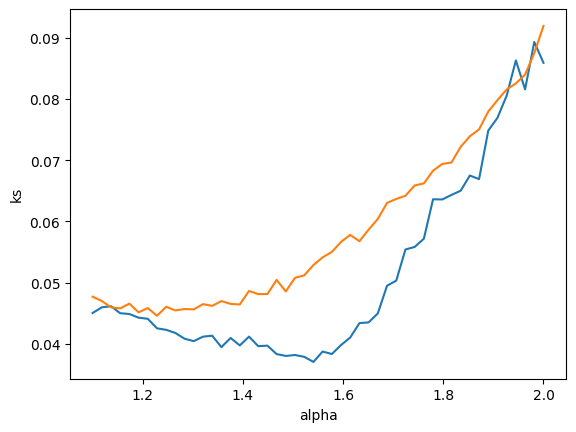

In [62]:
# sns.lineplot(
#     df.groupby("alpha").agg({"ks":np.max}).reset_index(), x="alpha", y="ks")
sns.lineplot(
    df.groupby("alpha").agg({"ks":np.median}).reset_index(), x="alpha", y="ks")
sns.lineplot(
    df.groupby("alpha").agg({"ks":np.mean}).reset_index(), x="alpha", y="ks")

<Axes: ylabel='Frequency'>

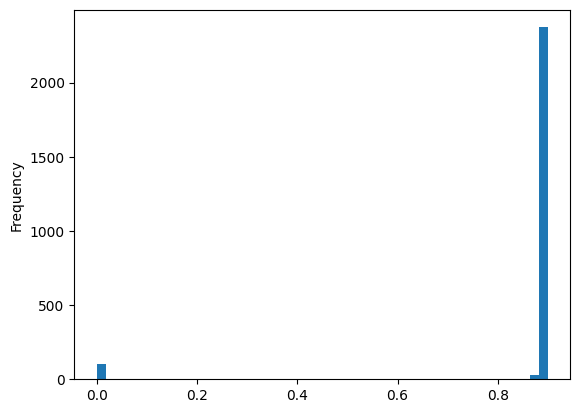

In [50]:
df["beta"].plot.hist(bins=50)

<Axes: ylabel='Frequency'>

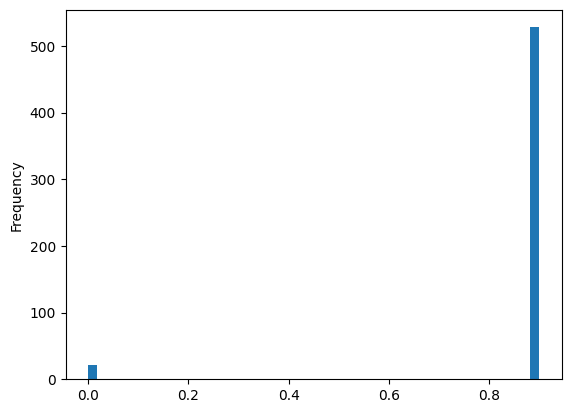

In [51]:
df[(df["alpha"] >= 1.4) & (df["alpha"] <= 1.6)]["beta"].plot.hist(bins=50)

In [16]:
locs = jnp.asarray([1.0, 1.1])
scales = 2.0
A = jnp.asarray([[1,2],[3,4],[5,6]])
b = jnp.asarray([[2,2,2]]).T
(beta1, loc1, scale1) = lsj.shift_scale(2.0, 0.0,locs, scales, A,b,"N1")
(beta1, loc1, scale1)

(Array([[0., 0.],
        [0., 0.],
        [0., 0.]], dtype=float32, weak_type=True),
 Array([[3. , 4.2],
        [5. , 6.4],
        [7. , 8.6]], dtype=float32),
 Array([[ 2.,  4.],
        [ 6.,  8.],
        [10., 12.]], dtype=float32, weak_type=True))

In [17]:
lsj.sum(2.0, beta1, loc1, scale1, param="N1", axis=0)

(Array([0., 0.], dtype=float32),
 Array([15. , 19.2], dtype=float32),
 Array([11.83216, 14.96663], dtype=float32))

In [18]:
raise

RuntimeError: No active exception to reraise

In [ ]:
from levy_stable_jax.distribution import TAB_X_CUTOFF, NUM_X_POINTS, ALPHA_MIN, ALPHA_MAX, NUM_ALPHA_POINTS, BETA_MIN, BETA_MAX, NUM_BETA_POINTS
xs = np.linspace(-TAB_X_CUTOFF, TAB_X_CUTOFF, NUM_X_POINTS)
alphas = np.linspace(ALPHA_MIN, ALPHA_MAX, NUM_ALPHA_POINTS)
betas = np.linspace(BETA_MIN, BETA_MAX, NUM_BETA_POINTS)
dx = 2 * TAB_X_CUTOFF / NUM_X_POINTS
NUM_BETA_POINTS

In [ ]:
alpha_idx = 40
beta_idx = 43
ys = np.array(lpdf[:,alpha_idx,beta_idx])
alpha = alphas[alpha_idx]
beta = betas[beta_idx]
print("alpha",alpha,"beta",beta)
with levy_stable_jax._utils.set_stable("N0"):
    ys0 = sp_levy_stable.logpdf(xs, alpha=alpha, beta=beta)
sns.lineplot(x=xs, y=ys0)
sns.lineplot(x=xs, y=ys)


In [ ]:
beta

In [ ]:
sns.scatterplot(x=xs, y=np.gradient(lpdf[:,alpha_idx,beta_idx]))

In [ ]:
sns.scatterplot(x=xs, y=ys)

# Check random parameters

In [ ]:
prng = jax.random.PRNGKey(1)
ys = lsj.rvs(alpha=1.8, beta=-1.0,loc=10.0, scale=0.5,param="N1",prng=prng,shape=(1000,))

In [ ]:
sns.histplot(ys)

In [ ]:
import levy_stable_jax.estimation

In [ ]:
lsj.estimation.fit_ll(ys, alpha=1.8, beta=None, param="N1")